#### This simulation aims at evaluating the properties of two estimators for the population benefit of an individual treatment rule $ r $ (SYNTAX 2020)
François Grolleau June 24, 2021

$$  ARE(r)= \mathbb{E} [ \{ r(X) -e(X) \} \tau(X) ]  $$

$$  \widehat{ARE}(r)= n^{-1} \sum_{i=1}^{n} \{ r(X_i) - A_i \} \hat{\tau}(X_i)  $$

$$  ASRE(r)= \mathbb{E} [ p(X) \{ r(X) -e(X) \} \tau(X) ]  $$

$$  \widehat{ASRE}(r)= n^{-1} \sum_{i=1}^{n} \tilde{p}(X_i) \{ r(X_i) - A_i \} \hat{\tau}(X_i)  $$

- In the case of implementation of $ r $ at random with probability $ \alpha $
$$ \tilde{p}(X_i)=\alpha $$
- In the case of implementation of $ r $ with cognitive bias $ \alpha \in [0;1[ $
$$ \tilde{p}(X_i)=(1-|r (X_i) - \hat{e} (X_i) |)^{ \frac{1}{2}\log{ \frac{\alpha + 1}{1 - \alpha} } } $$

- In the case of implementation of $ r $ only when  $ (1 - \alpha) $ confidence interval for the predicted individualized Hazard Ratio does not cross 1
$$ \tilde{p}(X_i)=\mathbb{1}   { [ \exp\{ \log i_{hr}(X_i) - q_ { 1 - \alpha /2 } se_{ \log i_{hr(X_i)}  } \} -1 ]  [ \exp\{ \log i_{hr}(X_i) + q_ { 1 - \alpha /2 } se_{ \log i_{hr(X_i)} } \} -1 ] } > 0 $$

In [626]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
from tableone import TableOne, load_dataset
import random
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

#### Setting data generation parameters

In [834]:
n = 200  # size of each sample
sims = 1  # number of repeated samples
n_boots = 1000 # number of bootstrap iterations
np.random.seed(1015033030)

#### Generating data

In [835]:
ids = []  # Generating simulation IDs
for i in range(sims):
    ids.extend([i + 1] * n)

df = pd.DataFrame()
df['sim_id'] = ids

In [836]:
# Creating confounders
df['age'] = np.round(np.random.normal(65, 10, size=n * sims), 0)  
df['crcl_log'] = np.random.normal(np.log(110), 0.18, size=n * sims) - 0.005 * df['age']
df['crcl'] = np.exp(df['crcl_log'])
df['diabetes'] = np.random.binomial(n=1, p=st.logistic.cdf(-6.73 + 0.03 * df['crcl_log'] + 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims)
df['insulin'] = np.where(df['diabetes']==1,
                    np.random.binomial(n=1, p=st.logistic.cdf(-4.16 + 0.04 * df['crcl_log'] - 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims),
                         0)
df['lvef'] = np.random.beta(11, 7, size=n * sims)*100 - 0.06 * df['age']
df['smoking'] = np.random.binomial(n=1, p=.21, size=n * sims)
df['pvd'] = np.random.binomial(n=1, p=st.logistic.cdf(-5.62 + 0.03 * df['smoking'] - 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims)
df['copd'] = np.random.binomial(n=1, p=st.logistic.cdf(-2.71 + 0.03 * df['smoking'] + 0.01 * df['pvd']), size=n * sims)
                                
df['tvd_lmcad'] = st.betabinom.rvs(2, .4, .7, loc=0, size=n * sims, random_state=None) #nb 0=3vd only, 1=lmcad only, 2=both

# One-hot encoding
df['tvd'] = np.where(df['tvd_lmcad']==0, 1, 0)
df['lmcad'] = np.where(df['tvd_lmcad']==1, 1, 0)
df['both'] = np.where(df['tvd_lmcad']==2, 1, 0)

#### Define and run a function that generates anatomical SYNTAX scores

In [837]:
def sim_anat_syntax(tvd_lmcad):
    """simulate anatomic syntax scores from coronary disease type."""
    from zepid.sensitivity_analysis import trapezoidal
    
    dummy_mat=np.stack([tvd_lmcad==0, tvd_lmcad==1, tvd_lmcad==2], axis=1)
    
    tvd=trapezoidal(3,10,10,50, len(tvd_lmcad))
    lmcad=trapezoidal(4,20,20,50, len(tvd_lmcad))
    both=trapezoidal(7,10,30,60, len(tvd_lmcad))
    
    return(dummy_mat[:,0]*tvd + dummy_mat[:,1]*lmcad + dummy_mat[:,2]*both)

df['syntax']= np.round(sim_anat_syntax(df['tvd_lmcad']))

#### Plot the generated anatomical SYNTAX scores

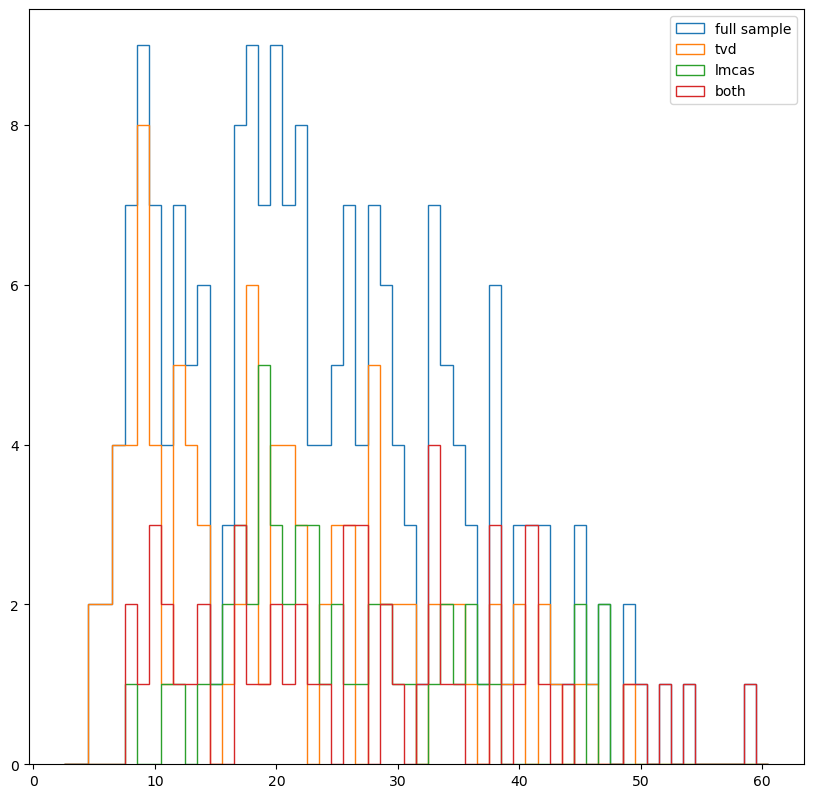

In [838]:
ind_tvd=df['tvd_lmcad']==0
ind_lmcad=df['tvd_lmcad']==1
ind_both=df['tvd_lmcad']==2

plt.figure(figsize=(10,10))
plt.hist(df['syntax'], histtype="step", bins=np.linspace(2.5,60.5, 59), label="full sample");
plt.hist(df['syntax'][ind_tvd], histtype="step", bins=np.linspace(2.5,60.5, 59), label="tvd");
plt.hist(df['syntax'][ind_lmcad], histtype="step", bins=np.linspace(2.5,60.5, 59), label="lmcas");
plt.hist(df['syntax'][ind_both], histtype="step", bins=np.linspace(2.5,60.5, 59), label="both");
plt.legend();

#### Plot LVEFs

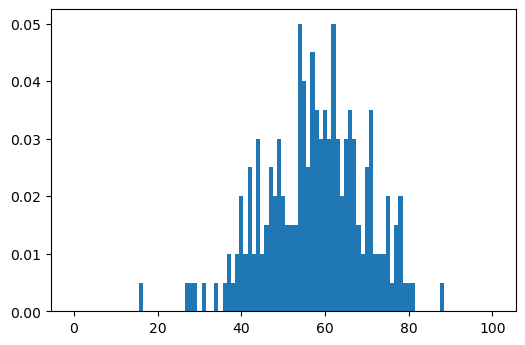

In [839]:
plt.hist(df.lvef, density=True, bins=np.linspace(-.5, 100.5, 102));

In [840]:
categorical = ['diabetes','insulin','smoking','pvd','copd','tvd_lmcad']
columns = ['age', 'crcl_log', 'diabetes', 'insulin', 'lvef', 'smoking', 'pvd','copd', 'tvd_lmcad']
#mytable = TableOne(df.iloc[0:n,:], columns = columns, categorical=categorical)
#print(mytable.tabulate(tablefmt="github"))

#### Treatment allocation mechanism (True Propensity Score)

In [841]:
df['cabg_pr'] = st.logistic.cdf(-2.971
                               + 0.049 * (df['age'] - 30)
                               - 0.001 * (df['age'] - 30)**2
                               + 0.212 * df['crcl_log']
                               + 0.973 * np.where(df['crcl_log'] > np.log(100), 1, 0)
                               - 0.386 * df['copd']
                               # Treatment-assignment based on disease type
                               + 1.973 * df['lmcad']
                               + 2.973 * df['both']
                               )
df['cabg'] = np.random.binomial(n=1, p=df['cabg_pr'], size=n*sims)

#### Potential outcomes

#### Define Syntax 2020 Model for predicting risk of all-cause death at 10 years
 as defined in Takahashi et al. Lancet 2020. Table 2

In [842]:
def syntax2020(age, crcl, lvef, copd, pvd, diabetes, insulin, smoking, tvd, lmcad, syntax, cabg):
    return 1-np.exp(-0.243 *np.exp(0.99 * (0.72*age/10 - 0.07 * np.where(crcl<90, crcl ,90)/10 -0.31 * np.where(lvef<50, lvef, 50)/10 + 0.48 * copd + 0.73 * pvd + 0.20 * diabetes 
                    + 0.46 * insulin + 0.66 * smoking)
                    - 0.4 * cabg * tvd - 0.08 * cabg * lmcad - 0.1 * (1 - cabg) * lmcad + .16 * (1-cabg) * (syntax - 29)/10 -2.80))

Reproduce first example from Takahashi et al. Lancet 2020
- Figure 1, Case 1, PCI scenario

In [843]:
syntax2020(age=74, crcl=38.6, lvef=40, copd=0, pvd=0, diabetes=0, insulin=0, smoking=1, tvd=0, lmcad=1, syntax=11, cabg=0)

0.5699878103841629

- Figure 1, Case 1, CABG scenario

In [844]:
syntax2020(age=74, crcl=38.6, lvef=40, copd=0, pvd=0, diabetes=0, insulin=0, smoking=1, tvd=0, lmcad=1, syntax=11, cabg=1)

0.6828410898159403

In [845]:
df['prY1'] = df.apply(lambda row : syntax2020(age=row['age'], crcl=np.exp(row['crcl_log']), lvef=row['lvef'],
                                copd=row['copd'], pvd=row['pvd'], diabetes=row['diabetes'],
                                 insulin=row['insulin'], smoking=row['smoking'], tvd=row['tvd_lmcad']==0,
                                 lmcad=row['tvd_lmcad']==1, syntax=row['syntax'],
                                 cabg=1), axis = 1)

df['Y1'] = np.random.binomial(n=1, p=df['prY1'], size=n*sims)

df['prY0'] = df.apply(lambda row : syntax2020(age=row['age'], crcl=np.exp(row['crcl_log']), lvef=row['lvef'],
                                copd=row['copd'], pvd=row['pvd'], diabetes=row['diabetes'],
                                 insulin=row['insulin'], smoking=row['smoking'], tvd=row['tvd_lmcad']==0,
                                 lmcad=row['tvd_lmcad']==1, syntax=row['syntax'],
                                 cabg=0), axis = 1)

df['Y0'] = np.random.binomial(n=1, p=df['prY0'], size=n*sims)

df['Y'] = np.where(df['cabg'] == 1, df['Y1'], df['Y0'])  # causal consistency

df['true_cate'] = df['prY1'] - df['prY0']

df['pred_cate'] = df['true_cate'] # as in this simulation the true CATEs are those predicted by the SYNTAX 2020 model.
df.head()

,sim_id,age,crcl_log,crcl,diabetes,insulin,lvef,smoking,pvd,copd,...,syntax,cabg_pr,cabg,prY1,Y1,prY0,Y0,Y,true_cate,pred_cate
0,1,59.0,4.444117,85.124671,0,0,52.654171,0,0,1,...,33.0,0.757340,1,0.173409,0,0.183749,0,0,-0.010339,-0.010339
1,1,54.0,4.663699,106.027512,0,0,68.712275,0,0,0,...,9.0,0.399081,1,0.052313,0,0.056544,0,0,-0.004231,-0.004231
2,1,58.0,4.342253,76.880591,0,0,67.785507,1,0,0,...,10.0,0.819144,1,0.201003,0,0.152593,0,0,0.048410,0.048410
3,1,60.0,4.222431,68.199096,0,0,62.544451,0,0,0,...,22.0,0.181555,0,0.091396,0,0.120002,0,0,-0.028606,-0.028606
4,1,56.0,4.260723,70.861187,0,0,59.322031,0,1,0,...,16.0,0.623228,1,0.181852,0,0.147679,1,0,0.034173,0.034173


In [846]:
categorical = ['Y','diabetes','insulin','smoking','pvd','copd','tvd_lmcad']
columns = ['Y', 'age', 'crcl_log', 'diabetes', 'insulin', 'lvef', 'smoking', 'pvd','copd', 'tvd_lmcad', 'syntax']
mytable = TableOne(df.iloc[0:n,:], columns = columns, categorical = categorical, groupby = "cabg")
print(mytable.tabulate(tablefmt="github"))

|                     |    | Missing   | Overall     | 0           | 1           |
|---------------------|----|-----------|-------------|-------------|-------------|
| n                   |    |           | 200         | 109         | 91          |
| Y, n (%)            | 0  | 0         | 133 (66.5)  | 74 (67.9)   | 59 (64.8)   |
|                     | 1  |           | 67 (33.5)   | 35 (32.1)   | 32 (35.2)   |
| age, mean (SD)      |    | 0         | 65.3 (11.1) | 66.2 (11.6) | 64.2 (10.4) |
| crcl_log, mean (SD) |    | 0         | 4.4 (0.2)   | 4.4 (0.2)   | 4.4 (0.2)   |
| diabetes, n (%)     | 0  | 0         | 150 (75.0)  | 82 (75.2)   | 68 (74.7)   |
|                     | 1  |           | 50 (25.0)   | 27 (24.8)   | 23 (25.3)   |
| insulin, n (%)      | 0  | 0         | 176 (88.0)  | 95 (87.2)   | 81 (89.0)   |
|                     | 1  |           | 24 (12.0)   | 14 (12.8)   | 10 (11.0)   |
| lvef, mean (SD)     |    | 0         | 57.5 (11.9) | 57.7 (12.1) | 57.4 (11.8) |
| sm

#### Predict individualized HRs with 95% CI for our simulated patients

In [847]:
def syntax_iHR_ci(df, alpha=.05):
    """Get individualized HR and 1-alpha CI from SYNTAX 2020,
    Uses table 2 predictive model coefficients and corresponding variance covariance matrix for the coefficients"""
    
    coef_mod2=np.array([0.99, -0.40, -0.08, -0.10, 0.16])
    VCOV=np.array(  [[3.17E-03, -1.58E-04, -2.68E-04,2.56E-04,-3.78E-04],
                     [-1.58E-04,1.53E-02,6.56E-03,6.48E-03,1.45E-04],
                     [-2.68E-04,6.56E-03,1.68E-02,6.47E-03,1.62E-04],
                     [2.56E-04,6.48E-03,6.47E-03,1.75E-02,-1.08E-03],
                     [-3.78E-04,1.45E-04,1.62E-04,-1.08E-03,2.84E-03]])
    
    X_cabg=np.stack([np.repeat(99,len(df)), 1* (df.tvd_lmcad==0), 1* (df.tvd_lmcad==1), 0 * np.array(df.tvd_lmcad==1), 0 * (df.syntax-29) / 10]).T # NB PIs don't contribute as it cancel out
    X_pci=np.stack([np.repeat(99,len(df)), 0* (df.tvd_lmcad==0), 0* (df.tvd_lmcad==1), 1 * np.array(df.tvd_lmcad==1), 1 * (df.syntax-29) / 10]).T # in the substraction (here set at 99)
    X_diff=X_cabg-X_pci
    log_iHR = X_diff.dot(coef_mod2)
    
    df_temp = df.copy()
    df_temp['pred_hr'] = np.exp(log_iHR)
    
    log_iHR_se=X_diff.dot(VCOV).dot(X_diff.T).diagonal() # X * VCOV * Xtranspose
    
    temp = np.stack( [log_iHR, log_iHR-st.norm.ppf(1-alpha/2)*log_iHR_se, log_iHR+st.norm.ppf(1-alpha/2)*log_iHR_se])
    iHR_CI = np.exp(temp.T)
    df_temp['iHR']= iHR_CI[:,0]
    df_temp['iHR_lb']= iHR_CI[:,1]
    df_temp['iHR_ub']= iHR_CI[:,2]
    
    significant = ((df_temp['iHR_lb']<1) == (df_temp['iHR_ub']<1))
    
    df_temp['significance'] = significant
    
    return df_temp

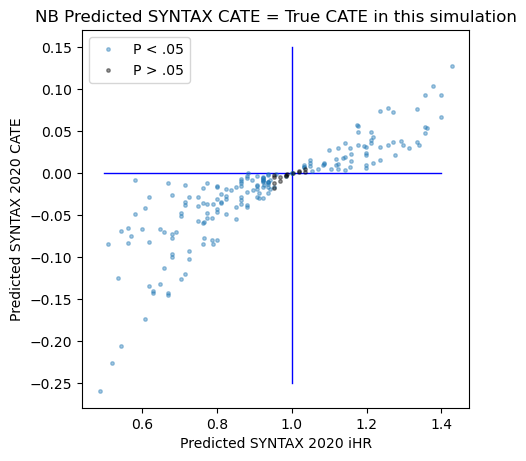

In [848]:
df_1 = df[df.sim_id==1]
df_1 = syntax_iHR_ci(df_1)

plt.figure(figsize=(5,5))
plt.plot([.5,1.4], [0,0], "b-", linewidth=1);
plt.plot([1,1], [-.25,.15], "b-", linewidth=1);
plt.plot(df_1['iHR'][df_1['significance']], df_1['true_cate'][df_1['significance']], 'o', markersize=2.5, alpha=.4, label="P < .05");
plt.plot(df_1['iHR'][~df_1['significance']], df_1['true_cate'][~df_1['significance']],'ko', markersize=2.5, alpha=.4, label="P > .05");
plt.title("NB Predicted SYNTAX CATE = True CATE in this simulation")
plt.xlabel("Predicted SYNTAX 2020 iHR")
plt.ylabel("Predicted SYNTAX 2020 CATE");
plt.legend();

#### A-learning

Matrix format implementation based on Tsiatis et al., Dynamic treatment regime. Statistical methods for precision medicine, eq (3.70) p. 76.

In [849]:
def A_learning(df, ctst_vrb, ps, nu, ttt, y):
    
    """A-learning algorithm
    Takes as input 
        df: pandas dataframe
        ctst_vrb: list of column names for contrast model fit
        ps: single column name of the predicted propensity scores
        nu: single column name of the predicted prognosis under treatment option 0
        ttt: single column name of the treatment option=1 (binary coding required 0/1)
        y: single column name of the outcome
        
    Contrast function is linear in the coefficients. Solution has linear algebra implementation.
    Output is a tuple of the contrast function coefficients and the in-sample CATE prediction"""
    
    H = df[ctst_vrb]
    H.insert(0, 'H_0', np.repeat(1, len(H)) )
    
    A = np.empty((len(ctst_vrb)+1, len(ctst_vrb)+1))
    for i in range(len(A)):
        for j in range(len(A)):
            A[i,j] =  np.sum(H.iloc[:,j] * H.iloc[:,i] * (df[ttt] - df[ps]) * df[ttt] )
    try:
        A_inverse = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        A_inverse = float("nan")
        print('Singular matrix, Nan output.')
    C = np.empty((len(ctst_vrb)+1,1))
    
    for i in range(len(C)):
        C[i] = np.sum(H.iloc[:,i] * (df[ttt] - df[ps]) * (df[y] - df[nu])) 
        
    psi_hat = np.dot(A_inverse, C)
    cate_hat = np.dot(H, psi_hat)
    return psi_hat, cate_hat

The following steps aims at obtaining the asymptotic variance of $ ARE $  from M-estimation theory (A-learning for $\hat{\tau} $ , PS & prognostic models trained through logistic regression) 

define the sigmoid i.e., expit function along its derivative

In [850]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

Define a program that compute the central element of the sandwitch forumla

In [851]:
def M_M_t(r_x, ttt, y, X_ctst, X_pr, X_ps, delta, ctst_icpt, ctst_coef, pr_icpt, pr_coef, ps_icpt, ps_coef, p_x):
    """Produces a (p1+p2+p3+4) * (p1+p2+p3+4) matrix M dot M transpose (central element of the sanwitch formula) """
    M = []
    for i in range(len(r_x)):
        M.append( np.empty((X_ctst.shape[1] + X_pr.shape[1] + X_ps.shape[1] + 4, 1) ) )
    
    # Delta (=ARE) estimating equation
        M[i][0] = p_x[i] * ( r_x[i] - ttt[i] ) * (ctst_icpt + np.dot(ctst_coef, X_ctst.iloc[i])) - delta
    
    # Contrast function estimating equations   
        M[i][1] = ( ttt[i] - sigmoid(ps_icpt + np.dot(ps_coef, X_ps.iloc[i])) ) * (y[i] - ttt[i] * (ctst_icpt + np.dot(ctst_coef, X_ctst.iloc[i]) ) - sigmoid(pr_icpt + np.dot(pr_coef, X_pr.iloc[i])) )
        
        for j in range(X_ctst.shape[1]):
            M[i][2+j] = X_ctst.iloc[i,j] * M[i][1]
    
    # Prognostic model estimating equations
        M[i][X_ctst.shape[1]+2] = y[i] - sigmoid(pr_icpt + np.dot(pr_coef, X_pr.iloc[i]) )
        
        for j in range(X_pr.shape[1]):
            M[i][X_ctst.shape[1]+3+j] = X_pr.iloc[i,j] * M[i][X_ctst.shape[1]+2]
            
    # PS model estimating equations
        M[i][X_ctst.shape[1]+X_pr.shape[1]+3] = ttt[i] - sigmoid(ps_icpt + np.dot(ps_coef, X_ps.iloc[i]) )
        
        for j in range(X_ps.shape[1]):
            M[i][X_ctst.shape[1]+X_pr.shape[1]+4+j] = X_ps.iloc[i,j] * M[i][X_ctst.shape[1]+X_pr.shape[1]+3]
    
    # Get list of M.dot(M.T)
    M_M_Ts = np.array([np.outer(element, element) for element in M])
    
    # Get element-wise mean of M_M_Ts
    M_M_T = np.mean(M_M_Ts, axis=0)
    
    return M_M_T

Define a program that compute the left-hand side element of the sandwitch forumla i.e., the inverse of the unbiaised estimating function M Jacobian Matrix's

In [852]:
def M_jacob_inv(r_x, ttt, y, X_ctst, X_pr, X_ps, delta, ctst_icpt, ctst_coef, pr_icpt, pr_coef, ps_icpt, ps_coef, p_x):
    """Produces the (p1+p2+p3+4) * (p1+p2+p3+4) inverse of the jacobian matrix of the M unbiaised estimating equations:
    estimator for the left end part of the sanwitch formula """
    
    dim = X_ctst.shape[1] + X_pr.shape[1] + X_ps.shape[1] + 4
    Jacob = [np.ones((dim,dim)) for _ in range(len(r_x))]
    
    for patient in range(len(X_pr)):
    
        ### ARE row 
        ## derivation wrt delta
        Jacob[patient][0,0] = -1

        ## derivation wrt psi0
        Jacob[patient][0,1] = p_x[patient] * (r_x[patient] - ttt[patient] )

        ## derivation wrt psi_s
        for ctst_var in range(len(X_ctst.columns)):
            Jacob[patient][0, 2 + ctst_var] = X_ctst.iloc[patient,ctst_var] * Jacob[patient][0,1]

        ## derivation wrt phi_s
        for pr_var in range(1 + len(X_pr.columns)):
            Jacob[patient][0, 2 + len(X_ctst.columns) + pr_var] = 0

        ## derivation wrt gamma0
        Jacob[patient][0, 2 + len(X_ctst.columns) + len(X_pr.columns) + 1] = 0

        ## derivation wrt gamma_s
        for ps_var in range(len(X_ps.columns)):
            Jacob[patient][0, 2 + len(X_ctst.columns) + len(X_pr.columns) + 1 + 1 + ps_var] = 0


        ### A-learning row 1
        ## derivation wrt delta
        Jacob[patient][1,0] = 0

        ## derivation wrt psi0
        Jacob[patient][1,1] =  ( sigmoid( ps_icpt + np.dot(ps_coef, X_ps.iloc[patient]) ) - ttt[patient] ) * ttt[patient]

        ## derivation wrt psi_s
        for ctst_var in range(len(X_ctst.columns)):
            Jacob[patient][1, 2 + ctst_var] =  X_ctst.iloc[patient, ctst_var] * Jacob[patient][1,1]

        ## derivation wrt phi0
        Jacob[patient][1, 2 + len(X_ctst.columns)] =  ( sigmoid( ps_icpt + np.dot(ps_coef, X_ps.iloc[patient]) ) - ttt[patient] ) * sigmoid_deriv( pr_icpt + np.dot(pr_coef, X_pr.iloc[patient]) )

        ## derivation wrt phi_s
        for pr_var in range(len(X_pr.columns)):
            Jacob[patient][1, 2 + len(X_ctst.columns) + 1 + pr_var] = X_pr.iloc[patient, pr_var] * Jacob[patient][1, 2 + len(X_ctst.columns)]

        ## derivation wrt gamma0
        Jacob[patient][1, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)] = - sigmoid_deriv( ps_icpt + np.dot(ps_coef, X_ps.iloc[patient]) ) * (y[patient] - ttt[patient] * ( ctst_icpt + np.dot(ctst_coef, X_ctst.iloc[patient]) ) - sigmoid( pr_icpt + np.dot(pr_coef, X_pr.iloc[patient] ) ) )

        ## derivation wrt gamma_s
        for ps_var in range(len(X_ps.columns)):
            Jacob[patient][1, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + ps_var] = X_ps.iloc[patient, ps_var] * Jacob[patient][1, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)]

        ### A-learning next rows
        for row in range(len(X_ctst.columns)):
            ## derivation wrt delta
            Jacob[patient][2 + row,0] = 0

            ## derivation wrt psi0
            Jacob[patient][2 + row, 1] =  X_ctst.iloc[patient, row] * Jacob[patient][1,1]

            ## derivation wrt psi_s
            for ctst_var in range(len(X_ctst.columns)):
                Jacob[patient][2 + row, 2 + ctst_var] =  X_ctst.iloc[patient, ctst_var] * Jacob[patient][2 + row, 1]

            ## derivation wrt phi0
            Jacob[patient][2 + row, 2 + len(X_ctst.columns)] =  X_ctst.iloc[patient, row] * Jacob[patient][1, 2 + len(X_ctst.columns)]

            ## derivation wrt phi_s
            for pr_var in range(len(X_pr.columns)):
                Jacob[patient][2 + row, 2 + len(X_ctst.columns) + 1 + pr_var] = X_pr.iloc[patient, pr_var] * Jacob[patient][2 + row, 2 + len(X_ctst.columns)]

            ## derivation wrt gamma0
            Jacob[patient][2 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)] = X_ctst.iloc[patient, row] * Jacob[patient][1, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)]

            ## derivation wrt gamma_s
            for ps_var in range(len(X_ps.columns)):
                Jacob[patient][2 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + ps_var] = X_ps.iloc[patient, ps_var] * Jacob[patient][2 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)]

        ### Prognosis row 1
        ## derivation wrt delta
        Jacob[patient][2 + len(X_ctst.columns), 0] = 0

        ## derivation wrt psi0
        Jacob[patient][2 + len(X_ctst.columns),1] = 0 

        ## derivation wrt psi_s
        for ctst_var in range(len(X_ctst.columns)):
            Jacob[patient][2 + len(X_ctst.columns), 2 + ctst_var] =  0

        ## derivation wrt phi0
        Jacob[patient][2 + len(X_ctst.columns), 2 + len(X_ctst.columns)] =  - sigmoid_deriv( pr_icpt + np.dot(pr_coef, X_pr.iloc[patient]) )

        ## derivation wrt phi_s
        for pr_var in range(len(X_pr.columns)):
            Jacob[patient][2 + len(X_ctst.columns), 2 + len(X_ctst.columns) + 1 + pr_var] =  X_pr.iloc[patient, pr_var] * Jacob[patient][2 + len(X_ctst.columns), 2 + len(X_ctst.columns)]

        ## derivation wrt gamma0
        Jacob[patient][2 + len(X_ctst.columns), 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)] = 0

        ## derivation wrt gamma_s
        for ps_var in range(len(X_ps.columns)):
            Jacob[patient][2 + len(X_ctst.columns), 2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + ps_var] = 0


        ### Prognosis next rows
        for row in range(len(X_pr.columns)):

            ## derivation wrt delta
            Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 0] = 0

            ## derivation wrt psi0
            Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 1] = 0 

            ## derivation wrt psi_s
            for ctst_var in range(len(X_ctst.columns)):
                Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 2 + ctst_var] =  0

            ## derivation wrt phi0
            Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 2 + len(X_ctst.columns)] =  X_pr.iloc[patient, row] * Jacob[patient][2 + len(X_ctst.columns), 2 + len(X_ctst.columns)]

            ## derivation wrt phi_s
            for pr_var in range(len(X_pr.columns)):
                Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 2 + len(X_ctst.columns) + 1 + pr_var] =  X_pr.iloc[patient, pr_var] * Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 2 + len(X_ctst.columns)]

            ## derivation wrt gamma0
            Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)] = 0

            ## derivation wrt gamma_s
            for ps_var in range(len(X_ps.columns)):
                Jacob[patient][2 + len(X_ctst.columns) + 1 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + ps_var] = 0

        ### PS row 1
        ## derivation wrt delta
        Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 0] = 0

        ## derivation wrt psi0
        Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 1] = 0 

        ## derivation wrt psi_s
        for ctst_var in range(len(X_ctst.columns)):
            Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 2 + ctst_var] =  0

        ## derivation wrt phi0
        Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 2 + len(X_ctst.columns)] =  0

        ## derivation wrt phi_s
        for pr_var in range(len(X_pr.columns)):
            Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 2 + len(X_ctst.columns) + 1 + pr_var] =  0

        ## derivation wrt gamma0
        Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)] = - sigmoid_deriv( ps_icpt + np.dot(ps_coef, X_ps.iloc[patient]) )

        ## derivation wrt gamma_s
        for ps_var in range(len(X_ps.columns)):
            Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + ps_var] = X_ps.iloc[patient, ps_var] * Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_ctst.columns), 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)]

        ### PS next rows
        for row in range(len(X_ps.columns)):

            ## derivation wrt delta
            Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 0] = 0

            ## derivation wrt psi0
            Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 1] = 0 

            ## derivation wrt psi_s
            for ctst_var in range(len(X_ctst.columns)):
                Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 2 + ctst_var] =  0

            ## derivation wrt phi0
            Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 2 + len(X_ctst.columns)] =  0

            ## derivation wrt phi_s
            for pr_var in range(len(X_pr.columns)):
                Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 2 + len(X_ctst.columns) + 1 + pr_var] =  0

            ## derivation wrt gamma0
            Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)] = X_ps.iloc[patient, row] * Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns), 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)]

            ## derivation wrt gamma_s
            for ps_var in range(len(X_ps.columns)):
                Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + ps_var] = X_ps.iloc[patient, ps_var] * Jacob[patient][2 + len(X_ctst.columns) + 1 + len(X_pr.columns) + 1 + row, 2 + len(X_ctst.columns) + 1 + len(X_pr.columns)]
    
    # Get element-wise mean of the jacobian matrices
    Mean_Jacob = np.mean(Jacob, axis=0)
    
    # Return the inverse of this mean jacobian matrix
    return np.linalg.pinv(Mean_Jacob)

Define a program that performs all the steps from raw input and returns all parameters along the variance covariance matrix

In [922]:
np.isin(df['rule'].dropna().unique(), [0,1]).all()

True

In [959]:
def V_cov_mat(df, rule, ttt, y, ps_predictors, pronostic_predictors, ctst_vrb, p_x):
    
    """This program performs ARE through A-learning/Logistic regression and 
    returns all parameters along their variance covariance matrix from M-estimation theory
    ARE is the first parameter, its variance corresponds to the top left element in the VCV matrix"""
    
    df_temp = df.copy()

    ## A-learning step
    
    # Fit PS model
    from sklearn.linear_model import LogisticRegression
    ps_mod = LogisticRegression(max_iter=2000)
    ps_mod = ps_mod.fit(df[ps_predictors], df[ttt])
    df_temp["e_hat"] = ps_mod.predict_proba(df[ps_predictors])[:,1]      

    # Fit prognositic model
    # If outcome is binary use logistic regression
    if np.isin(df[y].dropna().unique(), [0,1]).all() == True:
    
        pr_mod = LogisticRegression(max_iter=2000)
        pronostic_predictors_A = pronostic_predictors.copy()
        pronostic_predictors_A.append(ttt)
        pr_mod1 = pr_mod.fit(df.loc[:,pronostic_predictors_A], df.loc[:,y])

        X = df.loc[:,pronostic_predictors]
        X[ttt] = np.repeat(0, len(X))        
        df_temp["y0_hat"] = pr_mod1.predict_proba(X)[:,1]
    
    # Else if outcome is continuous use linear regression
    else:
        from sklearn.linear_model import LinearRegression
        pr_mod = LinearRegression()
        pronostic_predictors_A = pronostic_predictors.copy()
        pronostic_predictors_A.append(ttt)
        pr_mod1 = pr_mod.fit(df.loc[:,pronostic_predictors_A], df.loc[:,y])

        X = df.loc[:,pronostic_predictors]
        X[ttt] = np.repeat(0, len(X))        
        df_temp["y0_hat"] = pr_mod1.predict(X)

    # Apply A-learning perse and get contrast ( coefficients, predictions )
    psi_hat, df_temp["cate_hat"] = A_learning(df = df_temp, ctst_vrb = ctst_vrb, ps = "e_hat", nu = "y0_hat", ttt = ttt, y = y)            
    
    # Compute ARE and organize all other parameters
    are_hat = np.array( np.mean( (df_temp[rule] - df_temp[ttt]) * df_temp.cate_hat) ).squeeze()
    
    psi_hat_icpt = psi_hat[0].squeeze()
    psi_hat_coef = psi_hat[1:].squeeze()
    
    phi_hat_icpt = pr_mod.intercept_.squeeze()
    
    if np.isin(df[y].dropna().unique(), [0,1]).all() == True: # .coef_ is 2 dimentional when fit with logistic regression
        phi_hat_coef = pr_mod.coef_[0,:-1].squeeze() # coef for treatment variable is excluded, was only present so that the model could be fit on all patients and not only those who did not receive ttt
    else:                                                     # .coef_ is 1 dimentional when fit with linear regression
        phi_hat_coef = pr_mod.coef_[:-1].squeeze()
        
    gamma_hat_icpt = ps_mod.intercept_.squeeze()
    gamma_hat_coef = ps_mod.coef_.squeeze()
    
    # Store parameters
    parameters = np.hstack([are_hat, psi_hat_icpt, psi_hat_coef, phi_hat_icpt, phi_hat_coef, gamma_hat_icpt, gamma_hat_coef ])

    # Compute Lateral estimator from the sandwitch formula
    Lat = M_jacob_inv(r_x = df_temp[rule],
      ttt = df_temp[ttt], 
      y = df_temp[y],
      X_ctst = df_temp.loc[:, ctst_vrb],
      X_pr = df_temp.loc[:, pronostic_predictors],
      X_ps = df_temp.loc[:, ps_predictors],
      delta = are_hat,
      ctst_icpt = psi_hat_icpt,
      ctst_coef = psi_hat_coef,
      pr_icpt = phi_hat_icpt,
      pr_coef = phi_hat_coef,
      ps_icpt = gamma_hat_icpt,
      ps_coef = gamma_hat_coef,
      p_x = p_x)
    
    # Compute Central estimator from the sandwitch formula
    Central = M_M_t(r_x = df_temp[rule],
      ttt = df_temp[ttt], 
      y = df_temp[y],
      X_ctst = df_temp.loc[:, ctst_vrb],
      X_pr = df_temp.loc[:, pronostic_predictors],
      X_ps = df_temp.loc[:, ps_predictors],
      delta = are_hat,
      ctst_icpt = psi_hat_icpt,
      ctst_coef = psi_hat_coef,
      pr_icpt = phi_hat_icpt,
      pr_coef = phi_hat_coef,
      ps_icpt = gamma_hat_icpt,
      ps_coef = gamma_hat_coef,
      p_x = p_x)
    
    # Compute the sandwitch formula for sigma
    Sigma = Lat.dot(Central).dot(Lat.T)
    
    # Get the variance covariance matrix
    VCV = Sigma / len(df_temp) 
    
    return parameters, VCV, are_hat, psi_hat_icpt, psi_hat_coef, phi_hat_icpt, phi_hat_coef, gamma_hat_icpt, gamma_hat_coef, df_temp["cate_hat"]

In [960]:
def V_cov_mat_fast(df_temp, rule, ttt, y, ps_predictors, pronostic_predictors, ctst_vrb, p_x, are_hat, psi_hat_icpt, psi_hat_coef, phi_hat_icpt, phi_hat_coef, gamma_hat_icpt, gamma_hat_coef):
    
    """Fast computation of all parameters VCV when parameters have been comptued elswhere and are passed to this program"""
    
    # Compute Lateral estimator from the sandwitch formula
    Lat = M_jacob_inv(r_x = df_temp[rule],
      ttt = df_temp[ttt], 
      y = df_temp[y],
      X_ctst = df_temp.loc[:, ctst_vrb],
      X_pr = df_temp.loc[:, pronostic_predictors],
      X_ps = df_temp.loc[:, ps_predictors],
      delta = are_hat,
      ctst_icpt = psi_hat_icpt,
      ctst_coef = psi_hat_coef,
      pr_icpt = phi_hat_icpt,
      pr_coef = phi_hat_coef,
      ps_icpt = gamma_hat_icpt,
      ps_coef = gamma_hat_coef,
      p_x = p_x)
    
    # Compute Central estimator from the sandwitch formula
    Central = M_M_t(r_x = df_temp[rule],
      ttt = df_temp[ttt], 
      y = df_temp[y],
      X_ctst = df_temp.loc[:, ctst_vrb],
      X_pr = df_temp.loc[:, pronostic_predictors],
      X_ps = df_temp.loc[:, ps_predictors],
      delta = are_hat,
      ctst_icpt = psi_hat_icpt,
      ctst_coef = psi_hat_coef,
      pr_icpt = phi_hat_icpt,
      pr_coef = phi_hat_coef,
      ps_icpt = gamma_hat_icpt,
      ps_coef = gamma_hat_coef,
      p_x = p_x)
    
    # Compute the sandwitch formula for sigma
    Sigma = Lat.dot(Central).dot(Lat.T)
    
    # Get the variance covariance matrix
    VCV = Sigma / len(df_temp) 
    
    return VCV

In [961]:
def asre_package(df, rule, ttt, y, ps_predictors, pronostic_predictors, ctst_vrb, est='ARE', alpha = .5, n_alphas=5, precision=3):
    
    """From a pandas dataframe, this program computes through A-learning the ARE or cognitive biais ASRE along their 95% confidence intervals."""
    
    df_temp = df.copy()

    p_x = np.repeat(1, len(df))
    
    parameters, VCV, are_hat, psi_hat_icpt, psi_hat_coef, phi_hat_icpt, phi_hat_coef, gamma_hat_icpt, gamma_hat_coef, df_temp["cate_hat"] = V_cov_mat(df_temp, rule, ttt, y, ps_predictors, pronostic_predictors, ctst_vrb, p_x)
    
    are_hat = parameters[0]
    se_are = np.sqrt(VCV[0,0])
    print('ARE = ' + str(np.round(are_hat, precision)) + '  95% CI (' + 
          str(np.round(parameters[0] - st.norm.ppf(.975) * se_are, precision)) + ' to ' + 
          str(np.round(parameters[0] + st.norm.ppf(.975) * se_are, precision)) + ')' )
    
    estimator = 'ARE'
    
    if est == 'ASRE_cb':
        estimator = 'ASRE_cb_' + str(alpha)

        def sigmoid(x):
            return 1/(1+np.exp(-x))
        
        ps_pred = sigmoid( gamma_hat_icpt + df_temp[ps_predictors].dot(gamma_hat_coef) )
        
        def legit(x):
            return .5 * np.log((x+1)/(1-x))
        
        p_x = ( 1 - np.abs( df_temp[rule] - ps_pred ) ) ** legit(alpha)
               
        VCV = V_cov_mat_fast(df_temp, rule, ttt, y, ps_predictors, pronostic_predictors, ctst_vrb, p_x, are_hat, psi_hat_icpt, psi_hat_coef, phi_hat_icpt, phi_hat_coef, gamma_hat_icpt, gamma_hat_coef)
        
        asre_hat = np.array( np.mean( p_x * (df_temp[rule] - df_temp[ttt]) * df_temp["cate_hat"]) ).squeeze()
        
        se_asre = np.sqrt(VCV[0,0])
        print('ASRE (cognitive biais ' + str(alpha) + ')' + ' = ' + str(np.round(asre_hat, precision)) + '  95% CI (' + 
        str(np.round(parameters[0] - st.norm.ppf(.975) * se_asre, precision)) + ' to ' + 
        str(np.round(parameters[0] + st.norm.ppf(.975) * se_asre, precision)) + ')' )
        
        alphas = np.linspace(0,1,n_alphas+1)[:-1]
        asre_hats = []
        asre_ses = []
        cb_mean_px_alphas = []
        
        for alpha in alphas:
            p_x_temp = ( 1 - np.abs( df_temp[rule] - ps_pred ) ) ** legit(alpha)
            VCV_temp = V_cov_mat_fast(df_temp, rule, ttt, y, ps_predictors, pronostic_predictors, ctst_vrb, p_x_temp, are_hat, psi_hat_icpt, psi_hat_coef, phi_hat_icpt, phi_hat_coef, gamma_hat_icpt, gamma_hat_coef)
            asre_hats.append( np.mean( p_x_temp * (df_temp[rule] - df_temp[ttt]) * df_temp["cate_hat"]) )
            asre_ses.append(np.sqrt(VCV_temp[0,0]))
            cb_mean_px_alphas.append( np.mean(p_x_temp) )
            
        asre_hats_lci = np.array(asre_hats) - st.norm.ppf(.975) * np.array(asre_ses)
        asre_hats_lci = np.append(asre_hats_lci, 0)
        
        asre_hats_uci = np.array(asre_hats) + st.norm.ppf(.975) * np.array(asre_ses)
        asre_hats_uci = np.append(asre_hats_uci, 0)
        
        alphas = np.append(alphas, 1)
        asre_hats = np.append(asre_hats, 0)
        cb_mean_px_alphas = np.append( np.array(cb_mean_px_alphas), 0 )
            
        fig, axs = plt.subplots(1, 2, figsize=(10,5))

        fig.suptitle("Impact of rule's stochastic implementation on the observational population provided", fontsize=11)
        axs[0].plot([0,1],[0, 0], color= "black", alpha=1, linewidth=.5, linestyle='solid')
        axs[0].plot([0,1],[are_hat, are_hat], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label=r'$\widehat{ARE}$')
        axs[0].plot(alphas, asre_hats, 'o', color= "tab:orange", label="Cognitive biais implementation")
        axs[0].fill_between(alphas, asre_hats_lci, asre_hats_uci, color="tab:orange", alpha=.1, label="95% Confidence Interval")

        axs[0].set_xlabel('Cognitive Biais', fontsize=10)
        axs[0].set_ylabel(r'$\widehat{ASRE}$', fontsize=20)

        axs[0].set_xlim([-.01,1])
        axs[1].set_xlim([-.01,1])
        
        if are_hat < 0:
            axs[0].set_ylim([ asre_hats_lci[0] + are_hat/10, np.max([asre_hats_uci[0], 0]) - are_hat/10 ])
            axs[1].set_ylim([ asre_hats_lci[0] + are_hat/10, np.max([asre_hats_uci[0], 0]) - are_hat/10 ])
            
        else:
            axs[0].set_ylim([ np.min([asre_hats_lci[0], 0]) - are_hat/10, asre_hats_uci[0] + are_hat/10 ])
            axs[0].set_ylim([ np.min([asre_hats_lci[0], 0]) - are_hat/10, asre_hats_uci[0] + are_hat/10 ])

        axs[1].plot([0,1],[0, 0], color= "black", alpha=1, linewidth=.5, linestyle='solid')
        axs[1].plot([0,1],[are_hat, are_hat], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label=r'$\widehat{ARE}$')
        axs[1].plot(cb_mean_px_alphas, asre_hats, 'o', color= "tab:orange", label="Cognitive biais implementation")
        axs[1].fill_between(cb_mean_px_alphas, asre_hats_lci, asre_hats_uci, color="tab:orange", alpha=.1, label="95% Confidence Interval")
        axs[1].set_xlabel('Fraction of the population implementing the rule', fontsize=10)
        
        axs[1].legend();
        
        print('\nIn a tuple, this program returs the ASRE plot as well as all parameters along their corresponding variance-covariance matrix.')
        print('Parameters are provided in the following order.')
        print(estimator + ', Contrast intercept, Contrast coefficients, Prognostic intercept, Prognostic coefficients, Propensity score intercept, Propensity score coefficients.')
        return fig, parameters, VCV
    
    else :
        print('\nIn a tuple, this program returs all parameters along their corresponding variance-covariance matrix.')
        print('Parameters are provided in the following order.')
        print(estimator + ', Contrast intercept, Contrast coefficients, Prognostic intercept, Prognostic coefficients, Propensity score intercept, Propensity score coefficients.')
        return parameters, VCV

In [962]:
type(df['Y'])

pandas.core.series.Series

Demonstrate how this works

ARE = 0.026  95% CI (-0.051 to 0.102)
ASRE (cognitive biais 0.5) = 0.008  95% CI (-0.004 to 0.056)

In a tuple, this program returs the ASRE plot as well as all parameters along their corresponding variance-covariance matrix.
Parameters are provided in the following order.
ASRE_cb_0.5, Contrast intercept, Contrast coefficients, Prognostic intercept, Prognostic coefficients, Propensity score intercept, Propensity score coefficients.


(<Figure size 1000x500 with 2 Axes>,
 array([ 2.55221381e-02,  1.92631496e-01, -5.33005920e-03,  3.56405527e-02,
        -9.92635212e-03, -8.71559630e+00, -8.15887541e-02,  1.71075479e-01,
        -9.27267011e-02,  5.78107726e-03,  1.23308006e-01, -1.45022418e-02,
         4.93168692e-03,  4.40202603e-01,  1.88205214e-03,  1.22725954e+00,
         1.58898456e+00,  2.93171423e-01, -1.07570105e+00, -2.23872596e-02,
         6.04264762e-01, -2.54498485e-01, -1.60251311e+00,  2.70509465e-02,
         1.58358675e+00]),
 array([[ 2.34565183e-04, -7.16137354e-04,  1.25709587e-05,
          1.65975891e-03,  1.03095496e-04, -2.22993223e-03,
         -8.21109198e-04, -4.95834503e-04, -9.12988526e-04,
          6.43191893e-06,  3.89774414e-05, -2.25513070e-06,
         -4.72898301e-04, -1.61517317e-04,  3.97164312e-06,
          1.95939513e-04,  4.10231648e-05,  4.38103962e-04,
          5.40904352e-05,  2.70616018e-05, -1.22098526e-03,
         -1.72422528e-04,  3.53957105e-03,  3.57846632e-03,


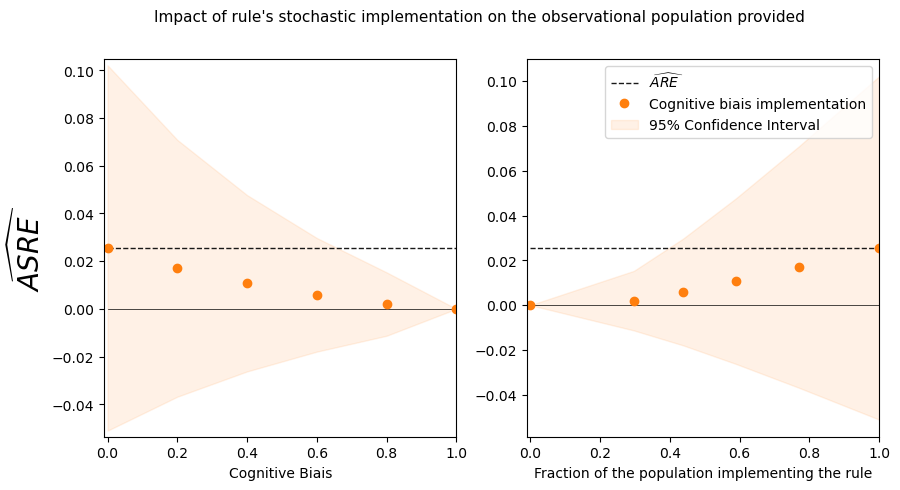

In [963]:
df['rule'] = df.pred_cate<0
#fig, asre_test, vcv_test = 
asre_package(df, 
          rule = "rule",
          ttt = 'cabg', y = "Y",
          ps_predictors = ["age", "crcl_log", "copd", "tvd", "lmcad", "both"],
          pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"],
          ctst_vrb = ['syntax', 'tvd', 'lmcad'],
          est='ASRE_cb', alpha = .5, n_alphas=5, precision=3)

#### X-learner

Implementation based on Kunzel et al., Metalearners for estimating heterogeneous treatment effects using machine learning, PNAS, 2019 <br>
with random forrest as base learners

In [754]:
def x_learner(df, pronostic_predictors, ttt, y, n_trees=100, max_features = "sqrt", e_hat = np.repeat(.5, len(df))):
    
    """X-learner algorythm with Random Forrest as base learners
    default weighting is e_hat=.5 but may be changed for a PS array"""
    
    try:
        pr_mod = RandomForestClassifier(n_estimators = n_trees, max_features = max_features)

        pr_mod1 = pr_mod.fit(df[df[ttt]==1].loc[:,pronostic_predictors], df[df[ttt]==1].loc[:,y])
        y1_hat = pr_mod1.predict_proba(df.loc[:,pronostic_predictors])[:,1]

        pr_mod0 = pr_mod.fit(df[df[ttt]==0].loc[:,pronostic_predictors], df[df[ttt]==0].loc[:,y])
        y0_hat = pr_mod0.predict_proba(df.loc[:,pronostic_predictors])[:,1]

        cate_imp1 = np.array(df[df[ttt]==1].loc[:,y] - y0_hat[df[ttt]==1])
        cate_imp0 = np.array(y1_hat[df[ttt]==0] - df[df[ttt]==0].loc[:,y])

        pr_mod = RandomForestRegressor(n_estimators=n_trees, max_features = max_features)

        tau1 = pr_mod.fit(df[df[ttt]==1].loc[:,pronostic_predictors], cate_imp1)
        tau1_hat = tau1.predict(df.loc[:,pronostic_predictors])

        tau0 = pr_mod.fit(df[df[ttt]==0].loc[:,pronostic_predictors], cate_imp0)
        tau0_hat = tau0.predict(df.loc[:,pronostic_predictors])

        cate_hat = (e_hat * tau0_hat) + (1 - e_hat) * tau1_hat
        
    except IndexError:
        cate_hat = np.repeat(float("nan"), len(df))
        print('IndexError in Random Forrest fit, Nan output.')
    return cate_hat

#### Define a generic function that will compute $ \hat{e}(x) $ and $ \hat{\tau}(x) $ for all simulated patients
- Uses either X-learner or A-learning as defined above
- PS and prognostic models are fitted through Random Forrests
- Tuning can be provided as `n_trees` and `max_features`
- See docstring for details

In [755]:
def ps_cate_preds(df, n_trees=100, max_features = "sqrt", 
                method='a',
                ttt = 'cabg', y = 'Y',
                ps_predictors = ["age", "crcl_log", "copd", "tvd", "lmcad", "both"],
                pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"],
                ctst_vrb = ['syntax', 'tvd', 'lmcad'],
                progress=1, step=10):
    
    """Compute PS and CATE from a dataset from X-Learner and A-learning for method = 'x' or 'a' respectively.
    ctst_vrb are the contrast function variables and need only be provided in the case of A-learning.
    Progress and step are merely printing arguments to follow progression while the function is being looped over.
    """   
    
    df_temp = df.copy()
    
    if method=="x":
        
        if isinstance(ps_predictors, pd.core.series.Series):
            e_hat = ps_predictors
            print('PS array provided, no model fitted')
        else:
            from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
            
            ps_mod = RandomForestClassifier(n_estimators = n_trees, max_features = max_features)
            ps_mod = ps_mod.fit(df[ps_predictors], df[ttt])
            e_hat = ps_mod.predict_proba(df[ps_predictors])[:,1]
        
        df_temp["e_hat"] = e_hat
        
        df_temp["cate_hat"] = x_learner(df_temp, n_trees=n_trees, e_hat = df_temp["e_hat"],
                               pronostic_predictors = pronostic_predictors, ttt=ttt, y=y)
    
    elif method=="a":
        
        from sklearn.linear_model import LogisticRegression
        ps_mod = LogisticRegression(max_iter=2000)
        ps_mod = ps_mod.fit(df[ps_predictors], df[ttt])
        df_temp["e_hat"] = ps_mod.predict_proba(df[ps_predictors])[:,1]      
        
        pr_mod = LogisticRegression(max_iter=2000)
        pronostic_predictors_A = pronostic_predictors.copy()
        pronostic_predictors_A.append(ttt)
        pr_mod1 = pr_mod.fit(df.loc[:,pronostic_predictors_A], df.loc[:,y])
        
        X = df.loc[:,pronostic_predictors]
        X[ttt] = np.repeat(0, len(X))        
        df_temp["y0_hat"] = pr_mod1.predict_proba(X)[:,1]
        
        df_temp["cate_hat"] = A_learning(df = df_temp, ctst_vrb = ctst_vrb, ps = "e_hat", nu = "y0_hat", ttt = ttt, y = y)[1]        
        
        df_temp.drop('y0_hat', axis=1, inplace=True)
        
    if progress % (step + 1) == 0:
        print(progress)
        
    return df_temp #, ps_mod.coef_, ps_mod.intercept_, pr_mod1.coef_, pr_mod1.intercept_

#### Apply with A-learning on the first dataset
- Contrast function, prognostic and PS models take relevant variables as inputs.

In [756]:
df_A = ps_cate_preds(df=df_1, method= 'a', n_trees=100, max_features = "sqrt", 
                    ttt = 'cabg', y = 'Y',
                    ps_predictors = ["age", "crcl_log", "copd", "tvd", "lmcad", "both"],
                    pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"],
                    ctst_vrb = ['syntax', 'tvd', 'lmcad'])

#### Apply with X-learner on the first dataset
- Prognostic take relevant variables as inputs, PScores is passed as an array and no model need to be reffitted for computational speed concerns, contrast function needs not be specified.

In [757]:
df_X = ps_cate_preds(df=df_1, method= 'x', n_trees=100, max_features = "sqrt", 
                    ttt = 'cabg', y = 'Y',
                    ps_predictors = ["age", "crcl_log", "copd", "tvd", "lmcad", "both"],
                    pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"],
                    ctst_vrb = [''])

#### Plot the "Goodness of fit" for the CATEs and PSs

A-learning:
Intercept = -0.024
Slope = 3.793
Pearson = 0.497

X-learner:
Intercept = 0.004
Slope = 0.26
Pearson = 0.051


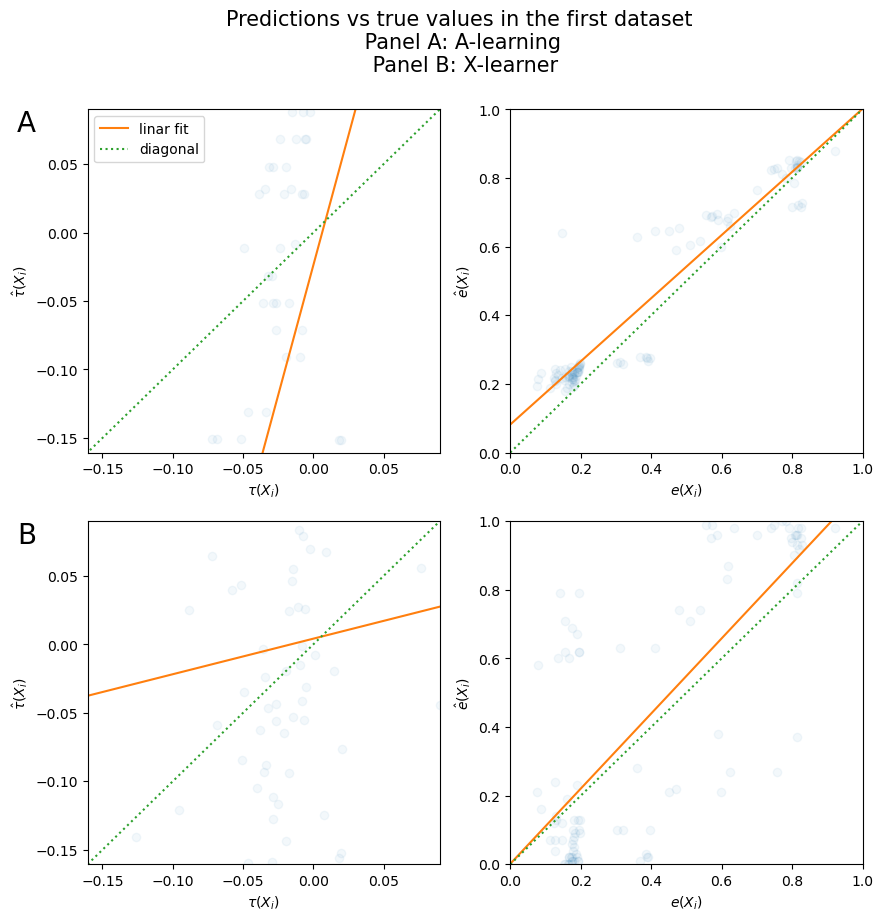

In [758]:
n_points = n

fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Predictions vs true values in the first dataset \n Panel A: A-learning \n Panel B: X-learner', size=15)

#### A-learning as base learner for the CATE
axs[0,0].text(-0.2, 1, "A", transform=axs[0,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[0,0].plot(df_A["true_cate"][:n_points], df_A["cate_hat"][:n_points], "o", alpha=.05);
axs[0,0].set_xlabel(r'$\tau(X_i)$')
axs[0,0].set_ylabel(r'$\hat{\tau}(X_i)$')

m, b = np.polyfit(df_A["true_cate"][:n_points], df_A["cate_hat"][:n_points], 1)
print('A-learning:')
print("Intercept = "+ str(np.round(b,3)))
print("Slope = "+ str(np.round(m,3)))
from scipy.stats import pearsonr
print("Pearson = " + str(np.round( pearsonr(df_A["true_cate"], df_A["cate_hat"])[0] , 3)) ) 

axs[0,0].plot([min(df_A["true_cate"]), max(df_A["true_cate"])], [m*min(df_A["true_cate"]) + b, m*max(df_A["true_cate"]) + b], label="linar fit")
axs[0,0].plot([-.4,.4], [-.4,.4], linestyle=":", label="diagonal")
axs[0,0].set_xlim([min(df_A["true_cate"]), max(df_A["true_cate"])])
axs[0,0].set_ylim([min(df_A["true_cate"]), max(df_A["true_cate"])])
axs[0,0].legend()


axs[0,1].plot(df_A["cabg_pr"][:n_points], df_A["e_hat"][:n_points], "o", alpha=.05);
axs[0,1].set_xlabel('$e(X_i)$')
axs[0,1].set_ylabel('$\hat{e}(X_i)$');

m, b = np.polyfit(df_A["cabg_pr"], df_A["e_hat"], 1)
axs[0,1].plot([0,1], m*np.array([0,1]) + b)
axs[0,1].plot([0,1], [0,1], linestyle=":", label="diagonal")
axs[0,1].set_xlim([0,1])
axs[0,1].set_ylim([0,1]);

#### X-learner as base learner for the CATE
axs[1,0].text(-0.2, 1, "B", transform=axs[1,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[1,0].plot(df_X["true_cate"][:n_points], df_X["cate_hat"][:n_points], "o", alpha=.05);
axs[1,0].set_xlabel(r'$\tau(X_i)$')
axs[1,0].set_ylabel(r'$\hat{\tau}(X_i)$')

m, b = np.polyfit(df_X["true_cate"][:n_points], df_X["cate_hat"][:n_points], 1)
print('\nX-learner:')
print("Intercept = "+ str(np.round(b,3)))
print("Slope = "+ str(np.round(m,3)))
from scipy.stats import pearsonr
print("Pearson = " + str(np.round( pearsonr(df_X["true_cate"], df_X["cate_hat"])[0] , 3)) ) 

axs[1,0].plot([min(df_X["true_cate"]), max(df_X["true_cate"])], [m*min(df_X["true_cate"]) + b, m*max(df_X["true_cate"]) + b], label="linar fit")
axs[1,0].plot([-.4,.4], [-.4,.4], linestyle=":", label="diagonal")
axs[1,0].set_xlim([min(df_X["true_cate"]), max(df_X["true_cate"])])
axs[1,0].set_ylim([min(df_X["true_cate"]), max(df_X["true_cate"])])


axs[1,1].plot(df_X["cabg_pr"][:n_points], df_X["e_hat"][:n_points], "o", alpha=.05);
axs[1,1].set_xlabel('$e(X_i)$')
axs[1,1].set_ylabel('$\hat{e}(X_i)$');

m, b = np.polyfit(df_X["cabg_pr"], df_X["e_hat"], 1)
axs[1,1].plot([0,1], m*np.array([0,1]) + b)
axs[1,1].plot([0,1], [0,1], linestyle=":", label="diagonal")
axs[1,1].set_xlim([0,1])
axs[1,1].set_ylim([0,1]);

#### Define functions for ARE and ASREs (three stochastic implementations as described below)

In [759]:
def compute_are_hat(df):
    """Compute ARE from a df where e_hat and cate_hat are provided"""
    # Do not need e_hat for are_hat computation
    # are_hat = np.mean( ( (df.pred_cate<0) - df.e_hat)*df.cate_hat)
    
    # In the expectation e_hat marginalizes to A (see notes for proof) 
    are_hat = np.mean( ( (df.pred_cate<0) - df.cabg)*df.cate_hat)
    
    return are_hat

In [760]:
def compute_r_asre_hat(df, alpha):
    """Compute uniform/random ASRE from a df where e_hat and cate_hat are provided
    alpha is the uniform/random parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = np.repeat(alpha, len(df))
    r_asre_hat = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg)*df_temp.cate_hat)
    return r_asre_hat

In [761]:
def compute_ci_asre_hat(df, alpha):
    """Compute CI ASRE from a df where e_hat and cate_hat are provided"""
    df_temp = syntax_iHR_ci(df, alpha)
    ci_asre_hat = np.mean( df_temp.significance * ( (df_temp.pred_cate<0) - df_temp.cabg)*df_temp.cate_hat)
    return ci_asre_hat

In [762]:
def legit(x):
    return .5 * np.log((x+1)/(1-x))

def compute_cb_asre_hat(df, alpha):
    """Compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['e_hat']) ) ** legit(alpha)
    cb_asre_hat = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg)*df_temp.cate_hat)
    return cb_asre_hat

#### Estimate ARE and ASREs in each imputed dataset
##### I/ Create a list of datasets

In [763]:
inds = np.arange(sims)+1

df_list=[]
for i in inds:
    df_list.append(df[df['sim_id']==i])

##### II/ Fit PS, pronostic (and contrast function) models in all `sims` datasets
- A-learning fits logistic regression models for PS and prognosis and has semi-parametric implementation for the contrast function
- X-learner fits four random forests for 'prognosis' and one for the PS
- Takes time in case of a large number of datasets to analyze
- Comprehensive list seems faster than parallelization through `from multiprocessing import Pool`

a) A-Learning 

In [764]:
dfs_ready_A = [ps_cate_preds(df=data, method= 'a', progress=progress, step=int(sims/10)) for progress, data in enumerate(df_list)]

0


b) X-learner

In [765]:
dfs_ready_X = [ps_cate_preds(df=data, method= 'x', progress=progress, step=int(sims/10)) for progress, data in enumerate(df_list)]

0


##### III/ Now, all ARE / ASREs computations below are instantaneous..

a) A-Learning 

In [766]:
are_hats_A = [compute_are_hat(i) for i in dfs_ready_A]

In [767]:
r_1_3_asre_hats_A = [compute_r_asre_hat(i, alpha=1/3) for i in dfs_ready_A]
r_2_3_asre_hats_A = [compute_r_asre_hat(i, alpha=2/3) for i in dfs_ready_A]

In [768]:
ci_95_asre_hats_A = [compute_ci_asre_hat(i, alpha=.05) for i in dfs_ready_A]
ci_55_asre_hats_A = [compute_ci_asre_hat(i, alpha=.45) for i in dfs_ready_A]

In [769]:
cb_1_3_asre_hats_A = [compute_cb_asre_hat(i, alpha=1/3) for i in dfs_ready_A]
cb_2_3_asre_hats_A = [compute_cb_asre_hat(i, alpha=2/3) for i in dfs_ready_A]

b) X-learner

In [770]:
are_hats_X = [compute_are_hat(i) for i in dfs_ready_X]

In [771]:
r_1_3_asre_hats_X = [compute_r_asre_hat(i, alpha=1/3) for i in dfs_ready_X]
r_2_3_asre_hats_X = [compute_r_asre_hat(i, alpha=2/3) for i in dfs_ready_X]

In [772]:
ci_95_asre_hats_X = [compute_ci_asre_hat(i, alpha=.05) for i in dfs_ready_X]
ci_55_asre_hats_X = [compute_ci_asre_hat(i, alpha=.45) for i in dfs_ready_X]

In [773]:
cb_1_3_asre_hats_X = [compute_cb_asre_hat(i, alpha=1/3) for i in dfs_ready_X]
cb_2_3_asre_hats_X = [compute_cb_asre_hat(i, alpha=2/3) for i in dfs_ready_X]

#### Import true values from `true_val.ipynb`
True values of the estimators were calculated using the true values $e(X_i)$ and $\tau(X_i)$ for a population of 20,000 individuals.

In [774]:
from ipynb.fs.full.true_val import true_are, true_1_3_r_asre, true_2_3_r_asre, true_95_ci_asre, true_55_ci_asre, true_1_3_cb_asre, true_2_3_cb_asre

ModuleNotFoundError: No module named 'ipynb.fs.full.true_val'

#### Plot results

NameError: name 'true_are' is not defined

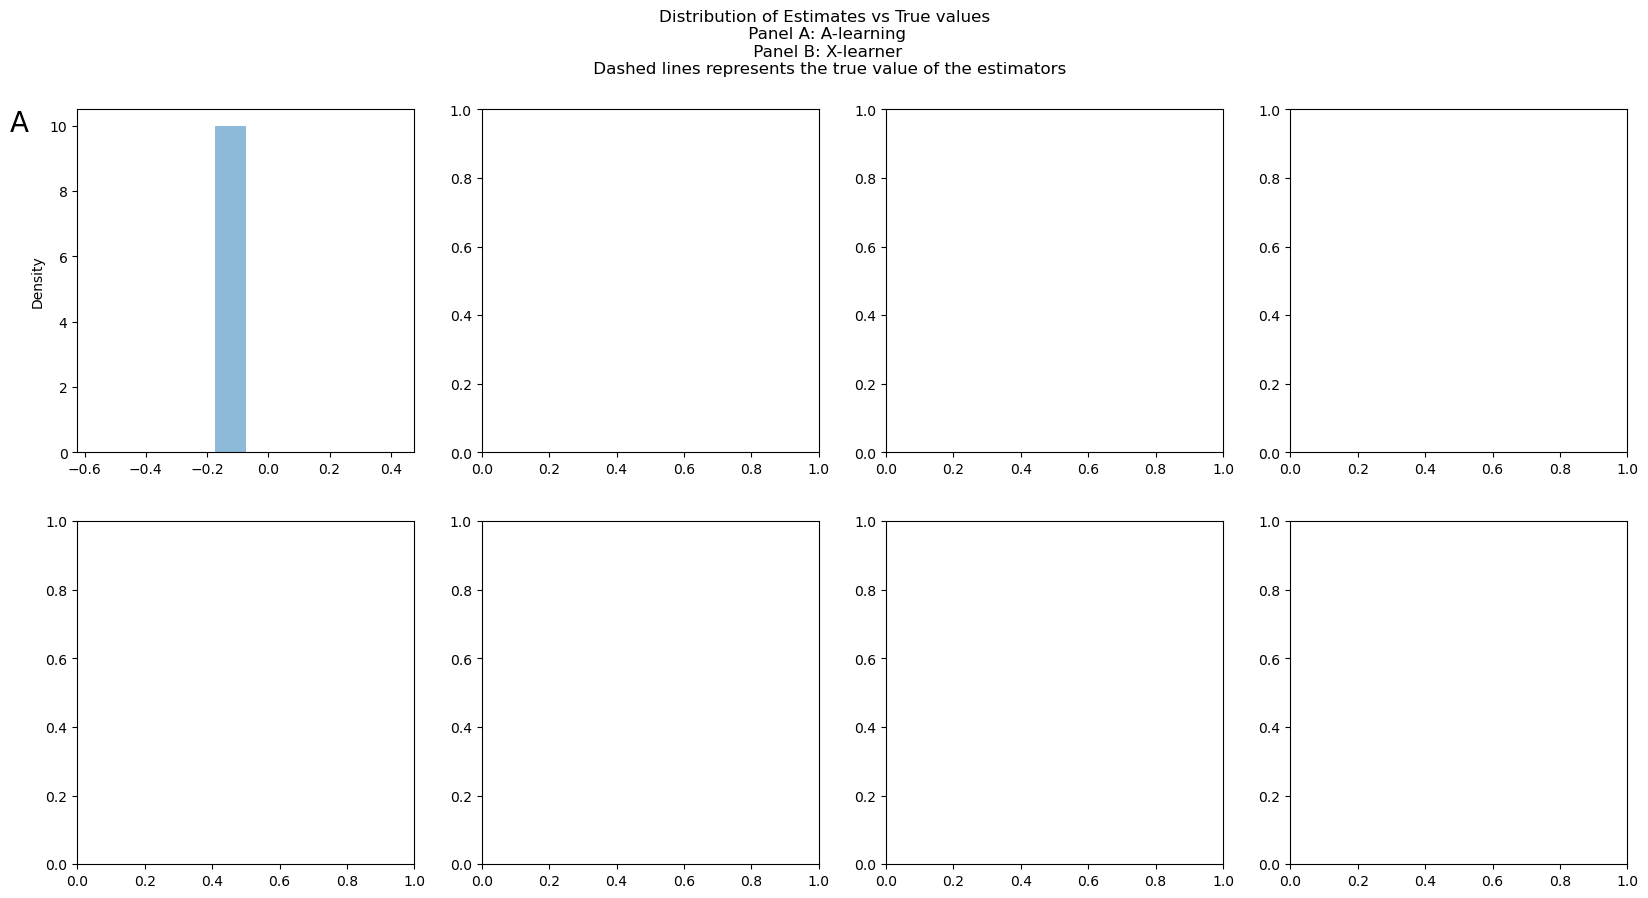

In [775]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

fig.suptitle('Distribution of Estimates vs True values \n Panel A: A-learning \n Panel B: X-learner \n Dashed lines represents the true value of the estimators')

#### A-learning as base learner for the CATE
axs[0,0].text(-0.2, 1, "A", transform=axs[0,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[0,0].hist(are_hats_A, density=True, alpha=.5);
axs[0,0].set_ylabel('Density');
axs[0,0].axvline(true_are, color='tab:blue', linestyle='dashed', linewidth=2)

axs[0,1].hist(r_1_3_asre_hats_A, density=True, alpha=.5, label="alpha=1/3");
axs[0,1].axvline(true_1_3_r_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[0,1].hist(r_2_3_asre_hats_A, density=True, alpha=.5, label="alpha=2/3");
axs[0,1].axvline(true_2_3_r_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[0,1].legend(loc='upper right')

axs[0,2].hist(ci_95_asre_hats_A, density=True, alpha=.5, label="alpha=0.05");
axs[0,2].axvline(true_95_ci_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[0,2].hist(ci_55_asre_hats_A, density=True, alpha=.5, label="alpha=0.45");
axs[0,2].axvline(true_55_ci_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[0,2].legend(loc='upper right')

axs[0,3].hist(cb_1_3_asre_hats_A, density=True, alpha=.5, label="alpha=1/3");
axs[0,3].axvline(true_1_3_cb_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[0,3].hist(cb_2_3_asre_hats_A, density=True, alpha=.5, label="alpha=2/3");
axs[0,3].axvline(true_2_3_cb_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[0,3].legend(loc='upper right');

#### X-learner as base learner for the CATE
axs[1,0].text(-0.2, 1, "B", transform=axs[1,0].transAxes, fontsize=20,
        verticalalignment='top')

axs[1,0].hist(are_hats_X, density=True, alpha=.5);
axs[1,0].set_xlabel('$\widehat{ARE}$');
axs[1,0].set_ylabel('Density');
axs[1,0].axvline(true_are, color='tab:blue', linestyle='dashed', linewidth=2)

axs[1,1].hist(r_1_3_asre_hats_X, density=True, alpha=.5, label="alpha=1/3");
axs[1,1].axvline(true_1_3_r_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[1,1].hist(r_2_3_asre_hats_X, density=True, alpha=.5, label="alpha=2/3");
axs[1,1].axvline(true_2_3_r_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[1,1].set_xlabel('$\widehat{ASRE}_{unif}$');
axs[1,1].legend(loc='upper right')

axs[1,2].hist(ci_95_asre_hats_X, density=True, alpha=.5, label="alpha=0.05");
axs[1,2].axvline(true_95_ci_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[1,2].hist(ci_55_asre_hats_X, density=True, alpha=.5, label="alpha=0.45");
axs[1,2].axvline(true_55_ci_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[1,2].set_xlabel('$\widehat{ASRE}_{ci}$');
axs[1,2].legend(loc='upper right')

axs[1,3].hist(cb_1_3_asre_hats_X, density=True, alpha=.5, label="alpha=1/3");
axs[1,3].axvline(true_1_3_cb_asre, color='tab:blue', linestyle='dashed', linewidth=2)
axs[1,3].hist(cb_2_3_asre_hats_X, density=True, alpha=.5, label="alpha=2/3");
axs[1,3].axvline(true_2_3_cb_asre, color='tab:orange', linestyle='dashed', linewidth=2)
axs[1,3].set_xlabel('$\widehat{ASRE}_{cb}$');
axs[1,3].legend(loc='upper right');

#### Relation between alpha and ASRE in each of the three three stochastic implementation scenarios

In [ ]:
#alphas = np.linspace(.0001,.9999,1000)
alphas = np.logspace(np.log10(1e-15), np.log10(.9999), 1000)

r_asre_hat_alphas = [compute_r_asre_hat(dfs_ready_A[1], alpha) for alpha in alphas]
ci_asre_hat_alphas = [compute_ci_asre_hat(dfs_ready_A[1], alpha) for alpha in alphas]
cb_asre_hat_alphas =[compute_cb_asre_hat(dfs_ready_A[1], alpha) for alpha in alphas]

are_hat = compute_are_hat(dfs_ready_A[1])

In [776]:
def compute_ci_px(df, alpha):
    """Returns p(x)s for CI ASRE from a df
    alpha is type I error"""
    significance = syntax_iHR_ci(df, alpha)['significance']
    return significance

def compute_cb_px(df, alpha):
    """Returns p(x)s for compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['e_hat']) ) ** legit(alpha)
    return df_temp['p_x']

ci_mean_px_alphas = [np.mean(compute_ci_px(dfs_ready_A[1], alpha)) for alpha in alphas]
cb_mean_px_alphas = [np.mean(compute_cb_px(dfs_ready_A[1], alpha)) for alpha in alphas]

IndexError: list index out of range

##### Compute true values fo ARE & ASREs

In [777]:
def compute_are_true(df):
    """Compute ARE from the true ps and cate"""
    are_true = np.mean( ( (df.pred_cate<0) - df.cabg_pr)*df.true_cate)
    return are_true

def compute_r_asre_true(df, alpha):
    """Compute uniform/random ASRE from the true ps and cate
    alpha is the uniform/random parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = np.repeat(alpha, len(df))
    r_asre_true = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return r_asre_true

def compute_ci_asre_true(df, alpha):
    """Compute CI ASRE from the true ps and cate"""
    df_temp = syntax_iHR_ci(df, alpha)
    ci_asre_true = np.mean( df_temp.significance * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return ci_asre_true

def compute_cb_asre_true(df, alpha):
    """Compute cognitive biais ASRE from the true ps and cate
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['cabg_pr']) ) ** legit(alpha)
    cb_asre_true = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return cb_asre_true

are_true = compute_are_true(dfs_ready_A[1])
r_asre_alphas_true = [compute_r_asre_true(dfs_ready_A[1], alpha) for alpha in alphas]
ci_asre_alphas_true = [compute_ci_asre_true(dfs_ready_A[1], alpha) for alpha in alphas]
cb_asre_alphas_true = [compute_cb_asre_true(dfs_ready_A[1], alpha) for alpha in alphas]

IndexError: list index out of range

##### Compute fraction of population following the rule under true cognitive biais (from true PS)

In [778]:
def compute_cb_px_true(df, alpha):
    """Returns p(x)s for compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['cabg_pr']) ) ** legit(alpha)
    return df_temp['p_x']

cb_mean_px_alphas_true = [np.mean(compute_cb_px_true(dfs_ready_A[1], alpha)) for alpha in alphas]

IndexError: list index out of range

##### Plot results

NameError: name 'are_hat' is not defined

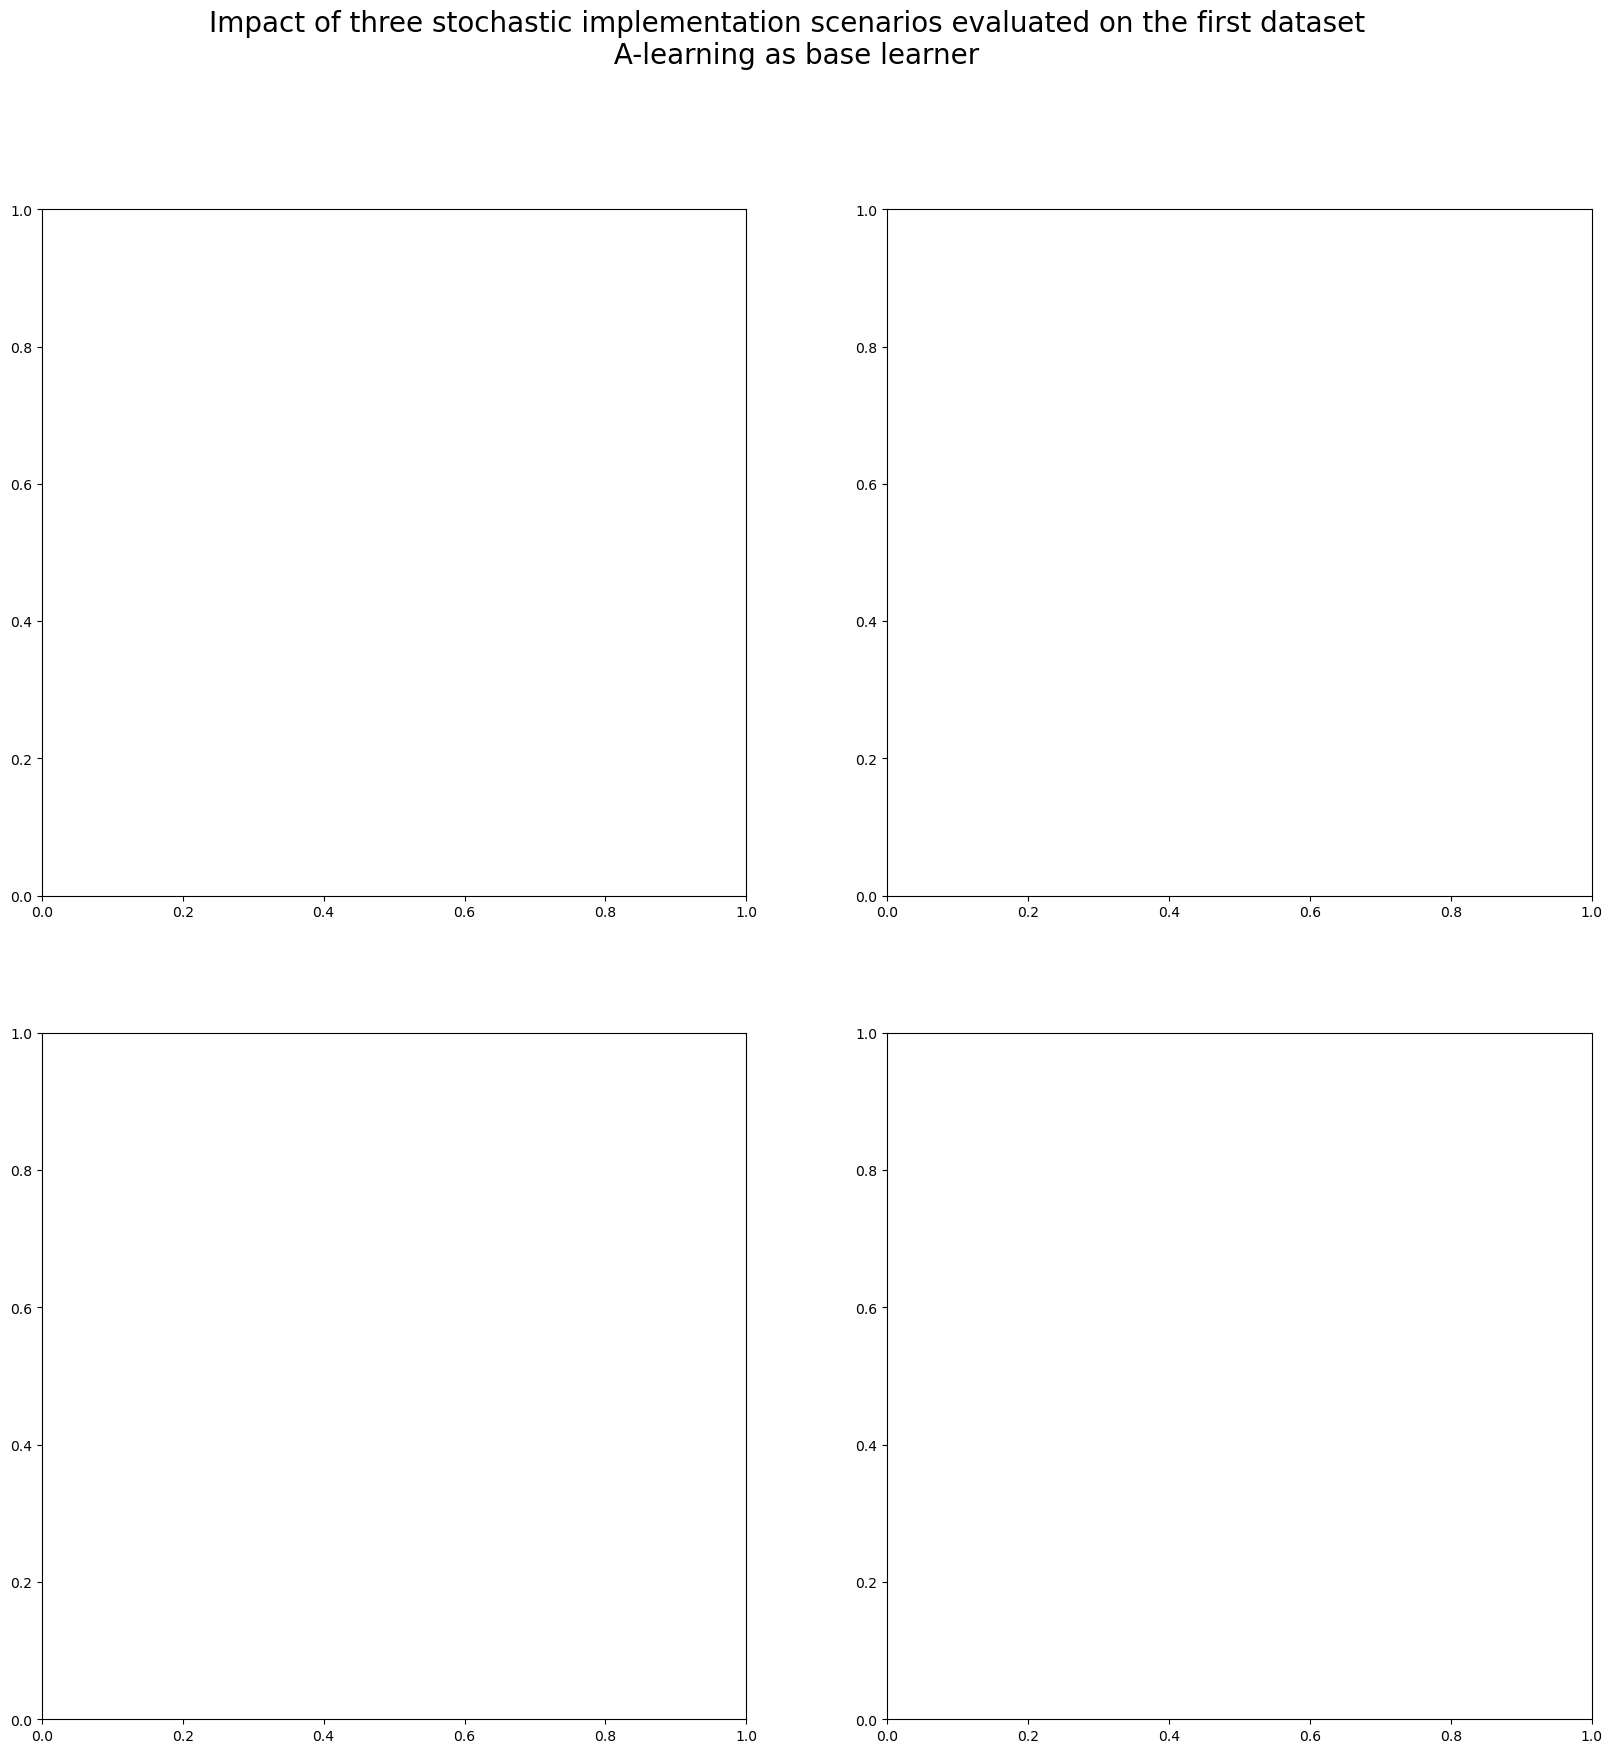

In [779]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))

fig.suptitle("Impact of three stochastic implementation scenarios evaluated on the first dataset \n A-learning as base learner", fontsize=20)
#ax1.plot([0,1],[0, 0], color= "black", alpha=1, linewidth=.5, linestyle='solid')

axs[0,0].plot([0,1],[are_hat, are_hat], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label=r'$\widehat{ARE}$')
axs[0,0].plot(alphas, r_asre_hat_alphas, color= "tab:blue", alpha=.9, label="Random implementation",)
axs[0,0].plot(alphas, cb_asre_hat_alphas, color= "tab:orange", alpha=.9, label="Cognitive biais implementation")
axs[0,0].plot(alphas, ci_asre_hat_alphas, color= "tab:green", alpha=.9, label="Confidence intervals implementation")

axs[0,0].set_xlabel(r'$\alpha$', fontsize=20)
axs[0,0].set_ylabel(r'$\widehat{ASRE}$', fontsize=20)
axs[0,0].legend(loc='upper center');

axs[0,0].set_xlim([-.01,1])
axs[0,0].set_ylim([are_hat-.001,.001])

axs[1,0].plot([0,1],[are_true, are_true], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label='TRUE $ARE$')
axs[1,0].plot(alphas, r_asre_alphas_true, color= "tab:blue", alpha=.9, label="TRUE Random implementation")
axs[1,0].plot(alphas, cb_asre_alphas_true, color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
axs[1,0].plot(alphas, ci_asre_alphas_true, color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")

axs[1,0].set_xlabel(r'$\alpha$', fontsize=20)
axs[1,0].set_ylabel(r'$ASRE$', fontsize=20)
axs[1,0].legend(loc='upper center');

axs[1,0].set_xlim([-.01,1])
axs[1,0].set_ylim([are_true-.001,.001])

axs[0,1].plot(alphas, r_asre_hat_alphas, "-", alpha=.9)
axs[0,1].plot(cb_mean_px_alphas, cb_asre_hat_alphas, "-", alpha=.9)
axs[0,1].plot(ci_mean_px_alphas, ci_asre_hat_alphas, "-", alpha=.9)

axs[0,1].set_xlabel(r'$\hat{E}[\hat{p}(X)]$', fontsize=20)
axs[0,1].set_ylabel(r'$\widehat{ASRE}$', fontsize=20)

#axs[0,1].set_xlim([.9,1])
#axs[0,1].set_ylim([are_hat,-.027]);

axs[1,1].plot(alphas, r_asre_alphas_true, color= "tab:blue", alpha=.9, label="TRUE Random implementation")
axs[1,1].plot(cb_mean_px_alphas_true, cb_asre_alphas_true, color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
axs[1,1].plot(ci_mean_px_alphas, ci_asre_alphas_true, color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")

axs[1,1].set_xlabel(r'$E[p(X)]$', fontsize=20)
axs[1,1].set_ylabel(r'$ASRE$', fontsize=20);

#axs[1,1].set_xlim([.9,1])
#axs[1,1].set_ylim([are_true,-.033]);

##### Zoom in on the bottom right figure

In [780]:
plt.figure(figsize=(10,10))
plt.plot(alphas, r_asre_alphas_true, "o", color= "tab:blue", alpha=.9, label="TRUE Random implementation")
plt.plot(cb_mean_px_alphas_true, cb_asre_alphas_true, "o", color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
plt.plot(ci_mean_px_alphas, ci_asre_alphas_true, "o", color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")
plt.xlim((.6,1))
plt.ylim((are_true, .6*are_true))
plt.legend()

plt.xlabel(r'$E[p(x)]$', fontsize=20)
plt.ylabel(r'$ASRE$', fontsize=20);

NameError: name 'r_asre_alphas_true' is not defined

<Figure size 1000x1000 with 0 Axes>


- Note that $ E[p(X)] $ can be interpreted as the fraction of the population following the rule

#### Bootstrap confidence intervals of $ \widehat{ARE} $ and $ \widehat {ASRE} $s

In [781]:
random.seed(4561) # Set seed for reproductibility.

#n_boots =  # Number of boostrap iterations is set on top of the notebook. 

# Generate resampling indexes.
resamples = []
for n_boot in range(n_boots):
    resamples.append([random.randint(0,n-1) for _ in range(n)])

##### I/ Check nominal coverage in the case where $ \hat{\tau}(x)$ is estimated via A-learning
- Compute all the information required in each boostrap resample

In [782]:
boot_computed_A = []    
for it, resample in enumerate(resamples):
    boot_computed_A.append( [ps_cate_preds(df=data.iloc[resample], method= 'a', progress=1) for data in df_list] )
    perc = int(100*it/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(it) + " i.e., " + str(perc)+"%")

Iteration 0 i.e., 0%
Iteration 1 i.e., 0%
Iteration 2 i.e., 0%
Iteration 3 i.e., 0%
Iteration 4 i.e., 0%
Iteration 5 i.e., 0%
Iteration 6 i.e., 0%
Iteration 7 i.e., 0%
Iteration 8 i.e., 0%
Iteration 9 i.e., 0%
Iteration 50 i.e., 5%
Iteration 51 i.e., 5%
Iteration 52 i.e., 5%
Iteration 53 i.e., 5%
Iteration 54 i.e., 5%
Iteration 55 i.e., 5%
Iteration 56 i.e., 5%
Iteration 57 i.e., 5%
Iteration 58 i.e., 5%
Iteration 59 i.e., 5%
Iteration 100 i.e., 10%
Iteration 101 i.e., 10%
Iteration 102 i.e., 10%
Iteration 103 i.e., 10%
Iteration 104 i.e., 10%
Iteration 105 i.e., 10%
Iteration 106 i.e., 10%
Iteration 107 i.e., 10%
Iteration 108 i.e., 10%
Iteration 109 i.e., 10%
Iteration 150 i.e., 15%
Iteration 151 i.e., 15%
Iteration 152 i.e., 15%
Iteration 153 i.e., 15%
Iteration 154 i.e., 15%
Iteration 155 i.e., 15%
Iteration 156 i.e., 15%
Iteration 157 i.e., 15%
Iteration 158 i.e., 15%
Iteration 159 i.e., 15%
Iteration 200 i.e., 20%
Iteration 201 i.e., 20%
Iteration 202 i.e., 20%
Iteration 203 i.e.

- Compute bootstrap estimates for all estimators

In [783]:
are_boots_A = np.ones((n_boots, sims))

asre_r_1_3_boots_A = np.ones((n_boots, sims))
asre_r_2_3_boots_A = np.ones((n_boots, sims))

asre_cb_1_3_boots_A = np.ones((n_boots, sims))
asre_cb_2_3_boots_A = np.ones((n_boots, sims))

asre_ci_95_boots_A = np.ones((n_boots, sims))
asre_ci_55_boots_A = np.ones((n_boots, sims))

for boot_i in range(n_boots):
    are_boots_A[boot_i] = np.array( [compute_are_hat(data) for data in boot_computed_A[boot_i]] )
    
    asre_r_1_3_boots_A[boot_i] = np.array( [compute_r_asre_hat(data, alpha=1/3) for data in boot_computed_A[boot_i]])
    asre_r_2_3_boots_A[boot_i] = np.array( [compute_r_asre_hat(data, alpha=2/3) for data in boot_computed_A[boot_i]])
    
    asre_cb_1_3_boots_A[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=1/3) for data in boot_computed_A[boot_i]])
    asre_cb_2_3_boots_A[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=2/3) for data in boot_computed_A[boot_i]])
    
    asre_ci_95_boots_A[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.05) for data in boot_computed_A[boot_i]])
    asre_ci_55_boots_A[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.45) for data in boot_computed_A[boot_i]])
    
    perc = int(100*boot_i/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(boot_i) + " i.e., " + str(perc)+"%")

Iteration 0 i.e., 0%
Iteration 1 i.e., 0%
Iteration 2 i.e., 0%
Iteration 3 i.e., 0%
Iteration 4 i.e., 0%
Iteration 5 i.e., 0%
Iteration 6 i.e., 0%
Iteration 7 i.e., 0%
Iteration 8 i.e., 0%
Iteration 9 i.e., 0%
Iteration 50 i.e., 5%
Iteration 51 i.e., 5%
Iteration 52 i.e., 5%
Iteration 53 i.e., 5%
Iteration 54 i.e., 5%
Iteration 55 i.e., 5%
Iteration 56 i.e., 5%
Iteration 57 i.e., 5%
Iteration 58 i.e., 5%
Iteration 59 i.e., 5%
Iteration 100 i.e., 10%
Iteration 101 i.e., 10%
Iteration 102 i.e., 10%
Iteration 103 i.e., 10%
Iteration 104 i.e., 10%
Iteration 105 i.e., 10%
Iteration 106 i.e., 10%
Iteration 107 i.e., 10%
Iteration 108 i.e., 10%
Iteration 109 i.e., 10%
Iteration 150 i.e., 15%
Iteration 151 i.e., 15%
Iteration 152 i.e., 15%
Iteration 153 i.e., 15%
Iteration 154 i.e., 15%
Iteration 155 i.e., 15%
Iteration 156 i.e., 15%
Iteration 157 i.e., 15%
Iteration 158 i.e., 15%
Iteration 159 i.e., 15%
Iteration 200 i.e., 20%
Iteration 201 i.e., 20%
Iteration 202 i.e., 20%
Iteration 203 i.e.

- Investigate asymptotic normality of bootstrap estimates in the first dataset

a) Compute original sample estimations for the first dataset

In [784]:
df_computed_A = ps_cate_preds(df=df_list[0], method= 'a', progress=1)

are_A = compute_are_hat(df_computed_A)
    
asre_r_1_3_A = compute_r_asre_hat(df_computed_A, alpha=1/3 )
asre_r_2_3_A = compute_r_asre_hat(df_computed_A, alpha=2/3 )
    
asre_cb_1_3_A = compute_cb_asre_hat(df_computed_A, alpha=1/3 )
asre_cb_2_3_A = compute_cb_asre_hat(df_computed_A, alpha=2/3 )
    
asre_ci_95_A = compute_ci_asre_hat(df_computed_A, alpha=.05 )
asre_ci_55_A = compute_ci_asre_hat(df_computed_A, alpha=.45 )


print 95% bootstrap CI for ARE (A-learning) in the first dataset and verify these are similar to 95% asymptotic CI from M-estimation

In [785]:
quantiles_temp = np.nanquantile(are_boots_A[:,0],[1-.05/2, .05/2])
ci_temp = np.multiply(2,are_A) - quantiles_temp
precision = 5

print('ARE (first dataset) = ' + str(np.round(are_A, precision)) + '  95% CI (' + str(np.round(ci_temp[0],precision))  +' to ' + str(np.round(ci_temp[1],precision)) + ')' )

ARE (first dataset) = -0.07352  95% CI (-0.25349 to 0.12741)


b) Plot Empirical Bootstrap Distribution as bootstrap percentile method is improper <br>
John Rice, Mathematical Statistics and Data Analysis, 3rd edition, p. 285.

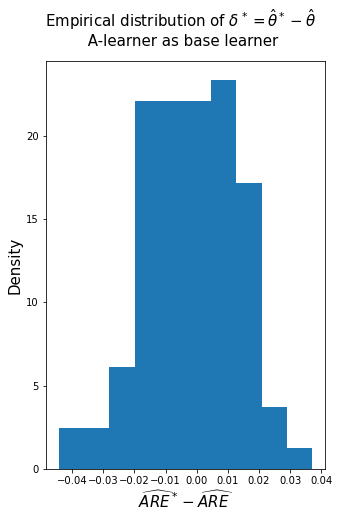

In [50]:
plt.figure(figsize=(5,7.5))
plt.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n A-learner as base learner", fontsize=15)

plt.hist(are_boots_A[:,0] - are_A, density=True);
plt.xlabel(r'$\widehat{ARE}^*-\widehat{ARE}$', fontsize=15);
plt.ylabel('Density', fontsize=15);

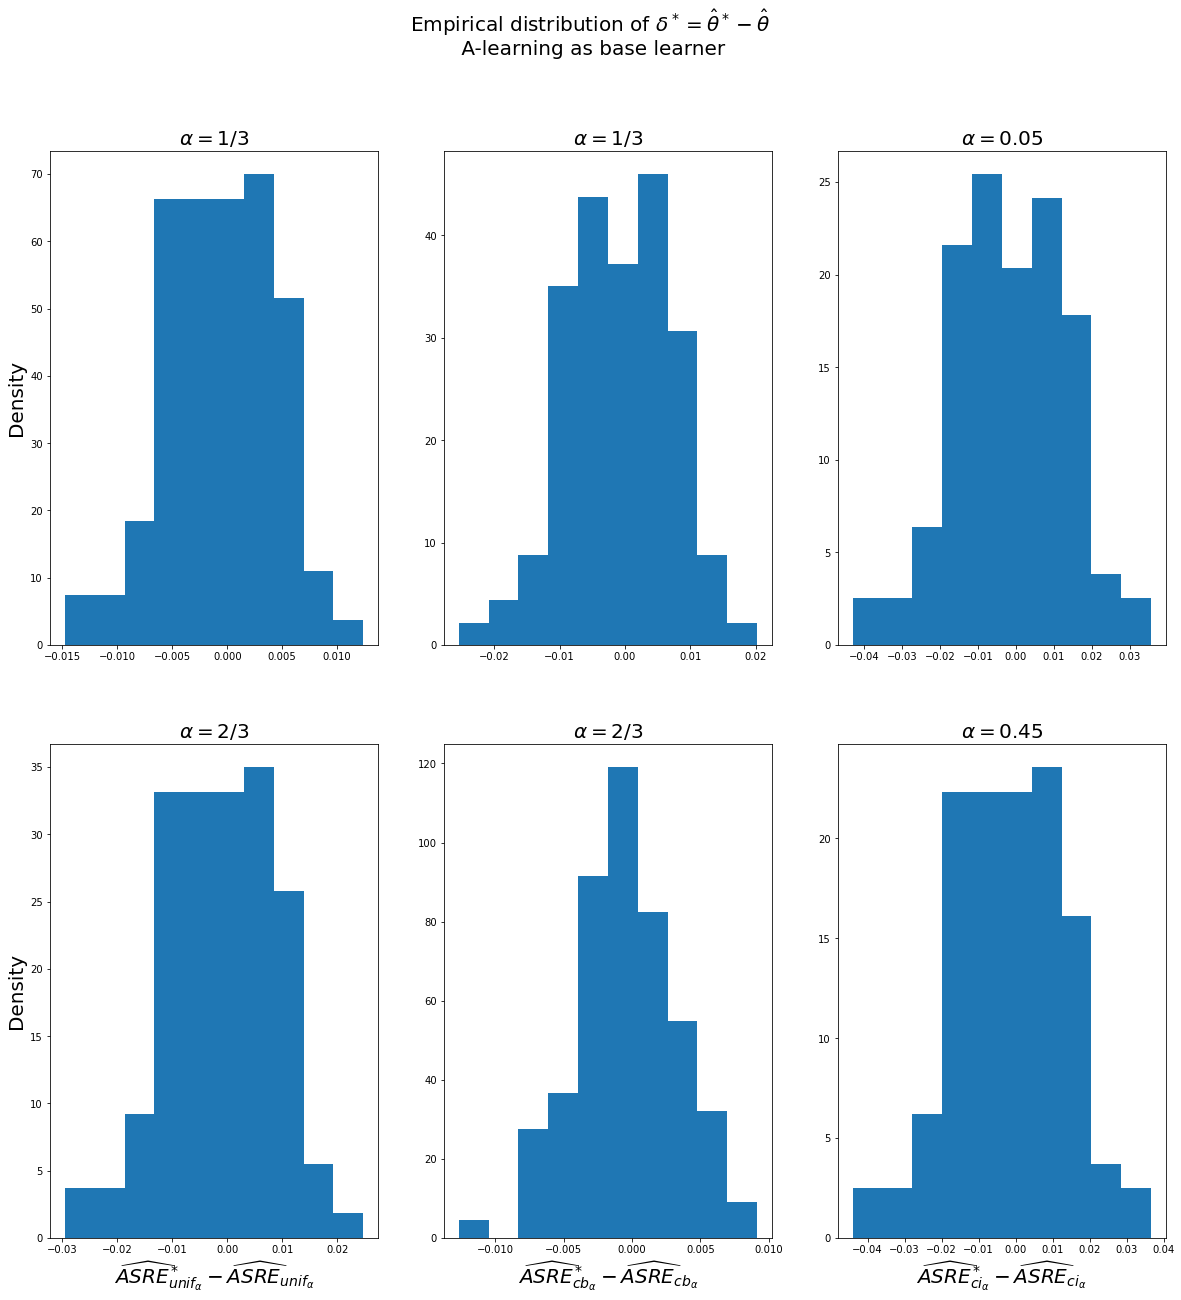

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))
fig.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n A-learning as base learner", fontsize=20)

axs[0,0].hist(asre_r_1_3_boots_A[:,0] - asre_r_1_3_A, density=True);
axs[0,0].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[0,0].set_ylabel('Density', fontsize=20)

axs[1,0].hist(asre_r_2_3_boots_A[:,0] - asre_r_2_3_A, density=True) ;
axs[1,0].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,0].set_xlabel(r'$\widehat{ASRE}_{unif_\alpha}^*-\widehat{ASRE}_{unif_\alpha}$', fontsize=20)
axs[1,0].set_ylabel('Density', fontsize=20)

axs[0,1].hist(asre_cb_1_3_boots_A[:,0] - asre_cb_1_3_A, density=True) ;
axs[0,1].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[1,1].hist(asre_cb_2_3_boots_A[:,0] - asre_cb_2_3_A, density=True) ;
axs[1,1].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,1].set_xlabel(r'$\widehat{ASRE}_{cb_\alpha}^*-\widehat{ASRE}_{cb_\alpha}$', fontsize=20)

axs[0,2].hist(asre_ci_95_boots_A[:,0] - asre_ci_95_A, density=True) ;
axs[0,2].set_title(r'$\alpha=0.05}$', fontsize=20)
axs[1,2].hist(asre_ci_55_boots_A[:,0] - asre_ci_55_A, density=True) ;
axs[1,2].set_title(r'$\alpha=0.45}$', fontsize=20)
axs[1,2].set_xlabel(r'$\widehat{ASRE}_{ci_\alpha}^*-\widehat{ASRE}_{ci_\alpha}$', fontsize=20);

- Compute empirical bootstrap CI for all $N=$`sims` datasets through the `empirical_boot_ci`function

- Empirirical bootstrap confidence intervals are $ [2 \hat{\theta} - q_{1 - \alpha/2} ; 2 \hat{\theta} - q_{\alpha/2}  ] $  as described in <br>
John Rice, Mathematical Statistics and Data Analysis, 3rd edition, p. 285.

- Calculate coverage for 95% empirirical bootstrap confidence intervals

In [52]:
def empirical_boot_ci(estimate, boot_estimates, risk_a):
    """outputs a list of empirical bootstrap CI from a list of estimates and a list of lists of bootstrap estimates"""
    quantiles = np.array([np.nanquantile(boot_estimates[:,dataset],[1-risk_a/2, risk_a/2]) for dataset in range(len(estimate))])
    return np.multiply(2,estimate).reshape(len(estimate),1)-quantiles

In [53]:
def coverage(true_value, estimate, boot_estimates, risk_a = .05):
    """outputs coverage from the true value of an estimator (scalar) and a (n_simulation * 2) matrix of confidence intervals"""
    
    ci_matrix = empirical_boot_ci(estimate=estimate, boot_estimates=boot_estimates, risk_a=risk_a)
    return np.sum([ bound[0] < true_value < bound[1] for bound in ci_matrix ]) / len(estimate)

In [54]:
cov_are_A = coverage(true_are, are_hats_A, are_boots_A, risk_a = .05)

cov_asre_r_1_3_A = coverage(true_1_3_r_asre, r_1_3_asre_hats_A, asre_r_1_3_boots_A, risk_a = .05) 
cov_asre_r_2_3_A = coverage(true_2_3_r_asre, r_2_3_asre_hats_A, asre_r_2_3_boots_A, risk_a = .05) 

cov_asre_cb_1_3_A = coverage(true_1_3_cb_asre, cb_1_3_asre_hats_A, asre_cb_1_3_boots_A, risk_a = .05) 
cov_asre_cb_2_3_A = coverage(true_2_3_cb_asre, cb_2_3_asre_hats_A, asre_cb_2_3_boots_A, risk_a = .05) 

cov_asre_ci_95_A = coverage(true_95_ci_asre, ci_95_asre_hats_A, asre_ci_95_boots_A, risk_a = .05) 
cov_asre_ci_55_A = coverage(true_55_ci_asre, ci_55_asre_hats_A, asre_ci_55_boots_A, risk_a = .05) 

- print the results for the 7 estimators considered

In [55]:
print(cov_are_A, cov_asre_r_1_3_A, cov_asre_r_2_3_A, cov_asre_cb_1_3_A, cov_asre_cb_2_3_A, cov_asre_ci_95_A, cov_asre_ci_55_A)

0.9 0.9 0.9 0.91 0.95 0.91 0.9


##### II/ Coverage check in the case where $ \hat{\tau}(x)$ is estimated via X-learner
- Compute all the information required in each boostrap resample
- To speed up computation PS models are not refitted and we re-use the predictions from PS models fitted during the A-learner procedure
- In the `ps_cate_preds`function, argument `ps_predictors=boot_computed_A[it][dataset_id].e_hat`can be used to bypass RF-PS fitting with previous LR-fits and speed up computations

In [56]:
boot_computed_X = []    
for it, resample in enumerate(resamples):
    boot_computed_X.append( [ps_cate_preds(df=data.iloc[resample], method= 'x', progress=1) for dataset_id, data in enumerate(df_list)] )
    perc = int(100*it/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(it) + " i.e., " + str(perc)+"%")

Iteration 0 i.e., 0%
Iteration 5 i.e., 5%
Iteration 10 i.e., 10%
Iteration 15 i.e., 15%
Iteration 20 i.e., 20%
Iteration 25 i.e., 25%
Iteration 30 i.e., 30%
Iteration 35 i.e., 35%
Iteration 40 i.e., 40%
Iteration 45 i.e., 45%
Iteration 50 i.e., 50%
Iteration 55 i.e., 55%
Iteration 60 i.e., 60%
Iteration 65 i.e., 65%
Iteration 70 i.e., 70%
Iteration 75 i.e., 75%
Iteration 80 i.e., 80%
Iteration 85 i.e., 85%
Iteration 90 i.e., 90%
Iteration 95 i.e., 95%
Iteration 99 i.e., 100%


- Compute bootstrap estimates for all estimators

In [57]:
are_boots_X = np.ones((n_boots, sims))

asre_r_1_3_boots_X = np.ones((n_boots, sims))
asre_r_2_3_boots_X = np.ones((n_boots, sims))

asre_cb_1_3_boots_X = np.ones((n_boots, sims))
asre_cb_2_3_boots_X = np.ones((n_boots, sims))

asre_ci_95_boots_X = np.ones((n_boots, sims))
asre_ci_55_boots_X = np.ones((n_boots, sims))

for boot_i in range(n_boots):
    are_boots_X[boot_i] = np.array( [compute_are_hat(data) for data in boot_computed_A[boot_i]] )
    
    asre_r_1_3_boots_X[boot_i] = np.array( [compute_r_asre_hat(data, alpha=1/3) for data in boot_computed_X[boot_i]])
    asre_r_2_3_boots_X[boot_i] = np.array( [compute_r_asre_hat(data, alpha=2/3) for data in boot_computed_X[boot_i]])
    
    asre_cb_1_3_boots_X[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=1/3) for data in boot_computed_X[boot_i]])
    asre_cb_2_3_boots_X[boot_i] = np.array( [compute_cb_asre_hat(data, alpha=2/3) for data in boot_computed_X[boot_i]])
    
    asre_ci_95_boots_X[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.05) for data in boot_computed_X[boot_i]])
    asre_ci_55_boots_X[boot_i] = np.array( [compute_ci_asre_hat(data, alpha=.45) for data in boot_computed_X[boot_i]])
    
    perc = int(100*boot_i/n_boot)
    if perc % 5 == 0:
        print("Iteration "+ str(boot_i) + " i.e., " + str(perc)+"%")

Iteration 0 i.e., 0%
Iteration 5 i.e., 5%
Iteration 10 i.e., 10%
Iteration 15 i.e., 15%
Iteration 20 i.e., 20%
Iteration 25 i.e., 25%
Iteration 30 i.e., 30%
Iteration 35 i.e., 35%
Iteration 40 i.e., 40%
Iteration 45 i.e., 45%
Iteration 50 i.e., 50%
Iteration 55 i.e., 55%
Iteration 60 i.e., 60%
Iteration 65 i.e., 65%
Iteration 70 i.e., 70%
Iteration 75 i.e., 75%
Iteration 80 i.e., 80%
Iteration 85 i.e., 85%
Iteration 90 i.e., 90%
Iteration 95 i.e., 95%
Iteration 99 i.e., 100%


- Investigate asymptotic normality of bootstrap estimates in the first dataset

a) Compute original sample estimations for the first dataset

In [58]:
df_computed_X = ps_cate_preds(df=df_list[0], method= 'x')

are_X = compute_are_hat(df_computed_X)
    
asre_r_1_3_X = compute_r_asre_hat(df_computed_X, alpha=1/3 )
asre_r_2_3_X = compute_r_asre_hat(df_computed_X, alpha=2/3 )
    
asre_cb_1_3_X = compute_cb_asre_hat(df_computed_X, alpha=1/3 )
asre_cb_2_3_X = compute_cb_asre_hat(df_computed_X, alpha=2/3 )
    
asre_ci_95_X = compute_ci_asre_hat(df_computed_X, alpha=.05 )
asre_ci_55_X = compute_ci_asre_hat(df_computed_X, alpha=.45 )



b) Plot Empirical Bootstrap Distribution as bootstrap percentile method is improper <br>
John Rice, Mathematical Statistics and Data Analysis, 3rd edition, p. 285.

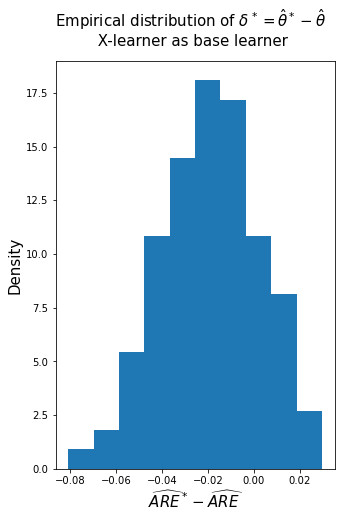

In [59]:
plt.figure(figsize=(5,7.5))
plt.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n X-learner as base learner", fontsize=15)

plt.hist(are_boots_X[0] - are_X, density=True);
plt.xlabel(r'$\widehat{ARE}^*-\widehat{ARE}$', fontsize=15);
plt.ylabel('Density', fontsize=15);

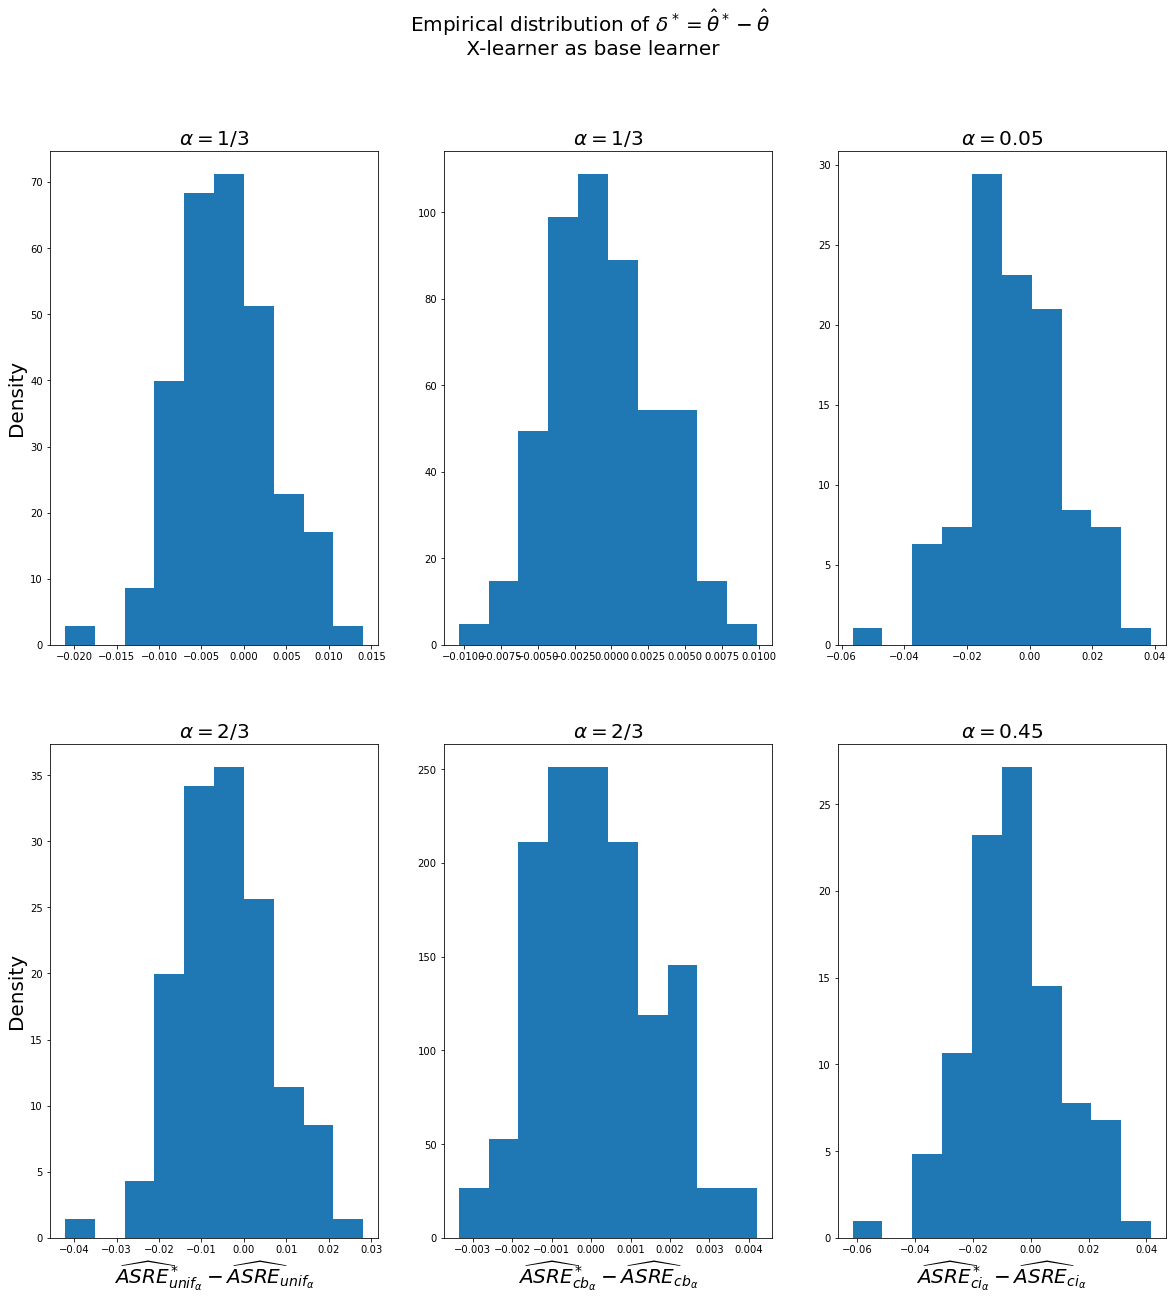

In [60]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))
fig.suptitle(r"Empirical distribution of $ \delta^*=\hat{\theta}^*-\hat{\theta} $" "\n X-learner as base learner", fontsize=20)

axs[0,0].hist(asre_r_1_3_boots_X[0] - asre_r_1_3_X, density=True);
axs[0,0].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[0,0].set_ylabel('Density', fontsize=20)

axs[1,0].hist(asre_r_2_3_boots_X[0] - asre_r_2_3_X, density=True) ;
axs[1,0].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,0].set_xlabel(r'$\widehat{ASRE}_{unif_\alpha}^*-\widehat{ASRE}_{unif_\alpha}$', fontsize=20)
axs[1,0].set_ylabel('Density', fontsize=20)

axs[0,1].hist(asre_cb_1_3_boots_X[0] - asre_cb_1_3_X, density=True) ;
axs[0,1].set_title(r'$\alpha=1/3}$', fontsize=20)
axs[1,1].hist(asre_cb_2_3_boots_X[0] - asre_cb_2_3_X, density=True) ;
axs[1,1].set_title(r'$\alpha=2/3}$', fontsize=20)
axs[1,1].set_xlabel(r'$\widehat{ASRE}_{cb_\alpha}^*-\widehat{ASRE}_{cb_\alpha}$', fontsize=20);

axs[0,2].hist(asre_ci_95_boots_X[0] - asre_ci_95_X, density=True) ;
axs[0,2].set_title(r'$\alpha=0.05}$', fontsize=20)
axs[1,2].hist(asre_ci_55_boots_X[0] - asre_ci_55_X, density=True) ;
axs[1,2].set_title(r'$\alpha=0.45}$', fontsize=20)
axs[1,2].set_xlabel(r'$\widehat{ASRE}_{ci_\alpha}^*-\widehat{ASRE}_{ci_\alpha}$', fontsize=20);

- Calculate coverage for 95% empirirical bootstrap confidence intervals

In [61]:
cov_are_X = coverage(true_are, are_hats_X, are_boots_X, risk_a = .05)

cov_asre_r_1_3_X = coverage(true_1_3_r_asre, r_1_3_asre_hats_X, asre_r_1_3_boots_X, risk_a = .05) 
cov_asre_r_2_3_X = coverage(true_2_3_r_asre, r_2_3_asre_hats_X, asre_r_2_3_boots_X, risk_a = .05) 

cov_asre_cb_1_3_X = coverage(true_1_3_cb_asre, cb_1_3_asre_hats_X, asre_cb_1_3_boots_X, risk_a = .05) 
cov_asre_cb_2_3_X = coverage(true_2_3_cb_asre, cb_2_3_asre_hats_X, asre_cb_2_3_boots_X, risk_a = .05) 

cov_asre_ci_95_X = coverage(true_95_ci_asre, ci_95_asre_hats_X, asre_ci_95_boots_X, risk_a = .05) 
cov_asre_ci_55_X = coverage(true_55_ci_asre, ci_55_asre_hats_X, asre_ci_55_boots_X, risk_a = .05) 

- print the results for the 7 estimators considered

In [62]:
print(cov_are_X, cov_asre_r_1_3_X, cov_asre_r_2_3_X, cov_asre_cb_1_3_X, cov_asre_cb_2_3_X, cov_asre_ci_95_X, cov_asre_ci_55_X)

0.61 0.67 0.67 0.26 0.2 0.67 0.67
